# Model Development and Training

In this Jupyter Notebook, you will develop and train the model.

In [3223]:
### Importing...
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import missingno as msno
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


### Connecting to PostgreSQL to access database

In [3224]:
# reads the whole API
conn2 = ps.connect(dbname = "postgres",
                   user = "postgres",
                   password = "postgres",
                   host = "localhost",
                   port = "5432")

In [3225]:
# connect area table
area_sql = """select * 
fROM public.area"""

# connect farm table
farm_sql = """select * 
fROM public.farm"""

# connect product table
product_sql = """select * 
fROM public.product"""

# connect sale_order table
so_sql = """select * 
fROM public.sale_order"""

# connect sale_order_item table
soi_sql = """select * 
fROM public.sale_order_item"""

# connect feedback table
feedback_sql = """select *
fROM public.feedback"""

# connect product_clicks table
product_clicks_sql = """select *
fROM public.product_clicks"""

# connect user_session table
user_session_sql = """select *
fROM public.user_session"""

In [3226]:
# read area table
area_df = sqlio.read_sql_query(area_sql, conn2)

# read farm table
farm_df = sqlio.read_sql_query(farm_sql, conn2)

# read product table
product_df = sqlio.read_sql_query(product_sql, conn2)

# read sale_order table
so_df = sqlio.read_sql_query(so_sql, conn2)

# read sale_order_item table
soi_df = sqlio.read_sql_query(soi_sql, conn2)

# read feedback table
feedback_df = sqlio.read_sql_query(feedback_sql, conn2)

# read product_clicks table
product_clicks_df = sqlio.read_sql_query(product_clicks_sql, conn2)

# read user_session table
user_session_df = sqlio.read_sql_query(user_session_sql, conn2)

C:\Users\user\AppData\Local\Temp\ipykernel_16588\440608200.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  area_df = sqlio.read_sql_query(area_sql, conn2)
C:\Users\user\AppData\Local\Temp\ipykernel_16588\440608200.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  farm_df = sqlio.read_sql_query(farm_sql, conn2)
C:\Users\user\AppData\Local\Temp\ipykernel_16588\440608200.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  product_df = sqlio.read_sql_query(product_sql, conn2)
C:\Users\user\AppData\Local\Temp\ipykernel_165

In [3227]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


In [3228]:
# show the first 5 rows of the area_df DataFrame
area_df.head()

,id,name,level_0,level_1,level_2,level_3,level_3_latitude,level_3_longitude,level_4,level_4_latitude,level_4_longitude
0,ID1101032013,"Ujung Pasir, Kluet Selatan, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Selatan,3.051660,97.459770,Ujung Pasir,3.079105,97.328659
1,ID1101142007,"Pucuk Lembang, Kluet Timur, Aceh Selatan, Aceh",Indonesia,Aceh,Aceh Selatan,Kluet Timur,3.171040,97.459770,Pucuk Lembang,3.161074,97.488838
2,ID1102022015,"Suka Maju, Lawe Sigala-Gala, Aceh Tenggara, Aceh",Indonesia,Aceh,Aceh Tenggara,Lawe Sigala-Gala,3.356980,97.926600,Suka Maju,3.356778,97.932930
3,ID1102032026,"Terutung Seperai, Bambel, Aceh Tenggara, Aceh",Indonesia,Aceh,Aceh Tenggara,Bambel,3.457160,97.904820,Terutung Seperai,3.454491,97.833214
4,ID1205012002,"Lau Damak, Bahorok, Langkat, Sumatera Utara",Indonesia,Sumatera Utara,Langkat,Bahorok,3.465968,98.046516,Lau Damak,3.472219,98.098335


In [3229]:
# show the first 5 rows of the farm_df DataFrame
farm_df.head()

,id,owner_id,area_id,latitude,longitude,area_hectare,planted_year,planted_month,palm_trees_per_hectare,soil_type,seed_type
0,f02bcded-3b72-43b9-8f14-f7687c4afbd9,145f7e51-c0e9-4dd3-b730-8dd03ee98c3a,ID1223052007,NaN,NaN,1.00,2015,4,125.0,Mineral,None
1,c18238d1-11ae-43eb-aa16-b9c2d14616dd,f6592c39-68a7-41e3-af84-b79d9a1a5540,ID1223052007,NaN,NaN,1.00,2025,4,125.0,Mineral,None
2,b519bade-60bf-4781-ba45-6e4803b005c6,4984b691-ed21-4188-b107-cde9bbe65d7f,ID1223052007,NaN,NaN,1.00,2025,4,125.0,Mineral,None
3,72f4944b-4ca5-40c6-9521-532886a91035,2f8ff664-d15f-44d9-9011-842f646e803f,ID1223052007,NaN,NaN,1.00,2016,4,125.0,Mineral,None
4,e355222d-1ec6-4a7b-9c0f-516a469b7f91,65df540b-c162-40e5-b806-cef9bd0139d7,ID1223052006,NaN,NaN,1000.25,2010,4,130.0,Mineral,None


In [3230]:
# show the first 5 rows of the product_df DataFrame
product_df.head()

,id,sku,type,unit_of_measurement,name,price,description
0,beb17fe4-5d92-4738-adaa-2d62ffb83516,101110503802,GOODS,kg,Urea Nitrea 46% N 50kg - Granul,356357.0,<p>Urea Nitrea 46% N 50kg Granul</p>
1,b67588d2-e8fe-4ee4-9931-e9d18241d04c,202310305001,GOODS,kg,PRIMASTAR 300/100 SL 5 liter,230000.0,"<h2 class=""ql-align-justify""><span style=""background-color: rgb(255, 255, 255); color: rgb(0, 0, 0);"">PRIMASTAR 300/100 SL : Herbisida sistemik purna tumbuh berbentuk larutan dalam air untuk mengendalikan gulma berdaun lebar dan gulma golongan rumput pada pertanaman kelapa sawit (TBM)</span></h2><p><br></p><h2><span style=""background-color: rgb(255, 255, 255); color: rgb(0, 0, 0);"">Bahan Aktif : Isopropil Amina Glifosat 300 g/l + 2,4-D Dimetil Amina 100 g/l</span></h2><p><br></p><h2 class=""ql-align-center""><span style=""background-color: rgb(8, 18, 138); color: rgb(255, 255, 255);"">Cara & Waktu Aplikasi</span></h2><p><br></p><h2><span style=""background-color: rgb(255, 255, 255); color: rgb(0, 0, 0);"">Penyemprotan volume tinggi dengan volume 400 - 600 l/ha. Aplikasi dimulai saat gulma tumbuh subur dan tidak turun hujan 4 - 6 jam setelah penyemprotan. Apabila belum jelas hubungi petugas pertanian yang berwenang</span></h2><p><br></p>"
2,c5e57af4-0df9-4e2b-87e4-9024b8e6cf53,202310304901,GOODS,kg,DMA 6 825 SL 400ml,97000.0,"<p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">DMA6 825 SL</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Berat bersih: 400ml</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Bahan aktif: 2,4-D dimetil amina (setara dengan 2,4-D: 686 g/l) : 825 g/l</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Produksi : Corteva Agriscience</span></p><p><br></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">DMA6 825 SL</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Herbisida sistemik selektif purna tumbuh yang berbentuk larutan dalam air berwarna coklat muda,sangat efektif untuk mengendalikan gulma di pertanaman padi, karet, teh dan tebu.</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Herbisida ini sudah tidak diragukan untuk tanaman padi sawah. yang berguna menberantas gulma daun lebar (Broadleaf) and teki tekian di sawah. juga sangat bagus untuk campuran ke glyphosate dan paraquat.</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Dapat digunakan pada tanaman: karet, padi, tebu, teh</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Herbisida sistemik purna tumbuh berbentuk larutan dalam air.</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Dosis :</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">– Karet (Gulma Berdaun Lebar) : 1,5 – 3 l/Ha</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Waktu Penyemprotan : Pada saat gulma masih muda dan aktif pertumbuhannya</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">– Teh (Gulma Berdaun Lebar) : 1 – 1,5 l/Ha</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Waktu Penyemprotan : Pada saat gulma masih muda dan aktif pertumbuhannya</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">– Tebu (Gulma Berdaun Lebar) : 1 – 2 l/Ha</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">Waktu Penyemprotan : Segera setelah tanam, atau 3 hari setelah tanam atau 14 hari setelah tanam</span></p><p><span style=""background-color: rgb(249, 249, 249); color: rgb(119, 119, 119);"">– Padi (Gulma Berdaun Lebar dan Teki

In [3231]:
# show the first 5 rows of the so_df DataFrame
so_df.head()

,id,user_id,total_item_price,created_at_utc0
0,74be876e-f74b-4633-b403-e07fa9861943,9c605d36-9c37-4f1e-bac1-c87146fae1f0,102000000.0,1744879059936
1,911a4c25-75d1-4f67-9a8a-40cb365b4cf0,49ad56f8-8d32-408f-9f88-36cad5310680,433200.0,1744875110464
2,e5819416-6b56-4337-9271-dc2c701ac7bd,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061
3,61e68625-9e6a-435d-9bdd-6c2187ca1817,49ad56f8-8d32-408f-9f88-36cad5310680,433200.0,1744868860328
4,667698fd-6694-4b97-b7f3-e993f1cd7756,231e825c-16af-4695-bda8-91deb60777e5,50000.0,1744859221323


In [3232]:
# show the first 5 rows of the soi_df DataFrame
soi_df.head()

,id,sale_order_id,product_id,quantity,price,clicked_from_recommendation,click_timestamp
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,False,None
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,None
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,None
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,None
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,None


In [3233]:
# show the first 5 rows of the feedback_df DataFrame
feedback_df.head()

,feedback_id,sales_order_id,rating,comment
0,e4a7c3f1-2d9b-486e-90c5-1d6f8b7a5e3c,d20a9066-aed8-4082-98e6-7abc62b7bf78,5,Exceeded expectations in every way!
1,9b8c7d6e-5f4a-43b2-a1c0-d9e8f7a6b5c4,ba87bf4a-4099-4101-84fb-ef0248fdf987,4,"Very good service, would recommend."
2,2f3e4d5c-6b7a-4897-a6b5-c4d3e2f1a0b9,e465e104-5248-4bd6-8650-4388f1a37e0f,3,"Average experience, nothing special."
3,a8b7c6d5-e4f3-4a2b-91c0-d9e8f7a6b5c4,86496962-031e-4f39-a78c-dd907bcd7322,5,"Absolutely perfect, couldn't ask for more."
4,5c6d7e8f-9a0b-4c1d-82e3-f4a5b6c7d8e9,a1c52691-d8de-4613-84f0-c78abf103cac,2,"Disappointed with quality, needs improvement."


In [3234]:
# show the first 5 rows of the product_clicks_df DataFrame
product_clicks_df.head()

,prodct_clicks_id,product_id,timestamp
0,b9c8d7e6-f5a4-4b3c-92d1-e0f9a8b7c6d5,0bd2430a-6613-442a-9d5a-11d64cb095ae,2025/05/01 08:05:00
1,3a4b5c6d-7e8f-4a0b-81c2-d3e4f5a6b7c8,1033503b-8faa-4d5c-97c2-50bb19fbb897,2025/03/17 14:32:45
2,e0f1a2b3-c4d5-4e6f-87a8-b9c0d1e2f3a4,1af0394e-3aea-42b4-8698-b6832e35f8ce,2025/07/29 09:18:22
3,7a8b9c0d-1e2f-4a3b-84c5-d6e7f8a9b0c1,2485b082-5258-44c1-b6aa-983387d540a7,2025/04/12 16:45:37
4,1e2f3a4b-5c6d-47e8-8f9a-0b1c2d3e4f5a,2b8fe2f0-5d07-459c-8781-22305a61980a,2025/06/05 11:09:54


In [3235]:
# show the first 5 rows of the user_session_df DataFrame
user_session_df.head()

,user_session_id,user_id,session_start,session_end
0,d20a9066-aed8-4082-98e6-7abc62b7bf78,05ebeca1-5a73-46ec-88fc-323b29d468cc,2025/03/15 09:23:17,2025/03/15 10:47:32
1,5f3c8b1a-6d24-4ea7-b519-f32c0e48d92c,7a341d40-7166-46d4-b37f-be9a9ecec7f7,2025/04/22 14:05:39,2025/04/22 15:38:51
2,a7f9e031-2bcd-4568-9174-8d26e0b7c943,34e01958-7a5d-4016-bb9a-e36d87ed3bf6,2025/01/08 18:32:45,2025/01/08 19:15:12
3,16eb7d42-5c9a-4f83-b0e5-3a192d4c6b87,917278db-9719-4988-a151-237f4fc74b9d,2025/07/19 08:17:23,2025/07/19 11:03:45
4,c8b53e9f-471d-4a20-9c8e-0b7d2f961a45,b93b8e2b-ffa7-4e29-bbf1-c90cce4c0962,2025/02/28 16:45:10,2025/02/28 17:22:38


In [3236]:
# show shape of the area_df DataFrame
area_df.shape

(46, 11)

In [3237]:
# show shape of the farm_df DataFrame
farm_df.shape

(100, 11)

In [3238]:
# show shape of the product_df DataFrame
product_df.shape

(41, 7)

In [3239]:
# show shape of the so_df DataFrame 
so_df.shape

(100, 4)

In [3240]:
# show shape of the soi_df DataFrame
soi_df.shape

(116, 7)

In [3241]:
# show shape of the feedback_df DataFrame
feedback_df.shape

(41, 4)

In [3242]:
# show shape of the product_clicks_df DataFrame
product_clicks_df.shape

(41, 3)

In [3243]:
# show shape of the user_session_df DataFrame
user_session_df.shape

(41, 4)

In [3244]:
# show data types of the area_df DataFrame
area_df.dtypes

id                    object
name                  object
level_0               object
level_1               object
level_2               object
level_3               object
level_3_latitude     float64
level_3_longitude    float64
level_4               object
level_4_latitude     float64
level_4_longitude    float64
dtype: object

In [3245]:
# show data types of the farm_df DataFrame
farm_df.dtypes

id                         object
owner_id                   object
area_id                    object
latitude                  float64
longitude                 float64
area_hectare              float64
planted_year                int64
planted_month               int64
palm_trees_per_hectare    float64
soil_type                  object
seed_type                  object
dtype: object

In [3246]:
# show data types of the product_df DataFrame
product_df.dtypes

id                      object
sku                     object
type                    object
unit_of_measurement     object
name                    object
price                  float64
description             object
dtype: object

In [3247]:
# show data types of the so_df DataFrame
so_df.dtypes

id                   object
user_id              object
total_item_price    float64
created_at_utc0       int64
dtype: object

In [3248]:
# show data types of the soi_df DataFrame
soi_df.dtypes

id                              object
sale_order_id                   object
product_id                      object
quantity                         int64
price                          float64
clicked_from_recommendation       bool
click_timestamp                 object
dtype: object

In [3249]:
# show data types of the feedback_df DataFrame
feedback_df.dtypes

feedback_id       object
sales_order_id    object
rating            object
comment           object
dtype: object

In [3250]:
# show data types of the product_clicks_df DataFrame
product_clicks_df.dtypes

prodct_clicks_id    object
product_id          object
timestamp           object
dtype: object

In [3251]:
# show data types of the user_session_df DataFrame
user_session_df.dtypes

user_session_id    object
user_id            object
session_start      object
session_end        object
dtype: object

In [3252]:
area_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 46 non-null     object 
 1   name               46 non-null     object 
 2   level_0            46 non-null     object 
 3   level_1            46 non-null     object 
 4   level_2            46 non-null     object 
 5   level_3            46 non-null     object 
 6   level_3_latitude   46 non-null     float64
 7   level_3_longitude  46 non-null     float64
 8   level_4            46 non-null     object 
 9   level_4_latitude   46 non-null     float64
 10  level_4_longitude  46 non-null     float64
dtypes: float64(4), object(7)
memory usage: 4.1+ KB


In [3253]:
farm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      100 non-null    object 
 1   owner_id                100 non-null    object 
 2   area_id                 100 non-null    object 
 3   latitude                2 non-null      float64
 4   longitude               2 non-null      float64
 5   area_hectare            100 non-null    float64
 6   planted_year            100 non-null    int64  
 7   planted_month           100 non-null    int64  
 8   palm_trees_per_hectare  48 non-null     float64
 9   soil_type               100 non-null    object 
 10  seed_type               28 non-null     object 
dtypes: float64(4), int64(2), object(5)
memory usage: 8.7+ KB


In [3254]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   41 non-null     object 
 1   sku                  41 non-null     object 
 2   type                 41 non-null     object 
 3   unit_of_measurement  41 non-null     object 
 4   name                 41 non-null     object 
 5   price                41 non-null     float64
 6   description          41 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.4+ KB


In [3255]:
so_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                100 non-null    object 
 1   user_id           100 non-null    object 
 2   total_item_price  100 non-null    float64
 3   created_at_utc0   100 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.3+ KB


In [3256]:
soi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           116 non-null    object 
 1   sale_order_id                116 non-null    object 
 2   product_id                   116 non-null    object 
 3   quantity                     116 non-null    int64  
 4   price                        116 non-null    float64
 5   clicked_from_recommendation  116 non-null    bool   
 6   click_timestamp              0 non-null      object 
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 5.7+ KB


In [3257]:
feedback_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   feedback_id     41 non-null     object
 1   sales_order_id  41 non-null     object
 2   rating          41 non-null     object
 3   comment         41 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [3258]:
product_clicks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   prodct_clicks_id  41 non-null     object
 1   product_id        41 non-null     object
 2   timestamp         41 non-null     object
dtypes: object(3)
memory usage: 1.1+ KB


In [3259]:
user_session_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_session_id  41 non-null     object
 1   user_id          41 non-null     object
 2   session_start    41 non-null     object
 3   session_end      41 non-null     object
dtypes: object(4)
memory usage: 1.4+ KB


In [3260]:
# show the statistics of the area_df DataFrame
area_df.describe()

,level_3_latitude,level_3_longitude,level_4_latitude,level_4_longitude
count,46.000000,46.000000,46.000000,46.000000
mean,0.356527,101.338789,0.359234,101.341713
std,3.117636,3.299132,3.118584,3.295200
min,-7.097770,97.459770,-7.129365,97.328659
25%,-1.641203,98.759658,-1.612830,98.774652
50%,1.689045,100.069371,1.625296,100.112301
75%,2.956138,102.949610,2.977077,102.942095
max,3.805560,113.846580,3.847265,113.861448


In [3261]:
# show the statistics of the farm_df DataFrame
farm_df.describe()  

,latitude,longitude,area_hectare,planted_year,planted_month,palm_trees_per_hectare
count,2.000000,2.000000,100.00000,100.000000,100.000000,48.000000
mean,-1.438965,102.842845,527.27470,2015.980000,5.170000,172.354167
std,2.756875,1.986315,1851.99293,5.750678,2.403932,155.785653
min,-3.388371,101.438309,0.50000,1999.000000,1.000000,1.000000
25%,-2.413668,102.140577,1.00000,2011.000000,4.000000,125.000000
50%,-1.438965,102.842845,1.00000,2017.000000,4.000000,130.000000
75%,-0.464263,103.545114,2.00000,2019.250000,7.000000,140.000000
max,0.510440,104.247382,10000.00000,2025.000000,12.000000,984.000000


In [3262]:
# show the statistics of the product_df DataFrame
product_df.describe()

,price
count,4.100000e+01
mean,5.036619e+05
std,3.751362e+05
min,3.500000e+04
25%,1.364400e+05
50%,4.693000e+05
75%,7.600000e+05
max,1.399999e+06


In [3263]:
# show the statistics of the so_df DataFrame
so_df.describe()

,total_item_price,created_at_utc0
count,1.000000e+02,1.000000e+02
mean,3.592171e+07,1.743403e+12
std,5.983375e+07,1.224087e+09
min,3.500000e+04,1.741151e+12
25%,4.217062e+05,1.742289e+12
50%,3.967432e+06,1.744048e+12
75%,6.825500e+07,1.744348e+12
max,3.345000e+08,1.744879e+12


In [3264]:
# show the statistics of the soi_df DataFrame
soi_df.describe()

,quantity,price
count,116.000000,116.000000
mean,102.034483,292514.732759
std,177.234795,130034.019829
min,1.000000,35000.000000
25%,1.000000,218093.750000
50%,10.000000,332500.000000
75%,200.000000,366250.000000
max,1000.000000,688750.000000


In [3265]:
# show the statistics of the feedback_df DataFrame
feedback_df.describe()

,feedback_id,sales_order_id,rating,comment
count,41,41,41,41
unique,41,38,5,41
top,e4a7c3f1-2d9b-486e-90c5-1d6f8b7a5e3c,d20a9066-aed8-4082-98e6-7abc62b7bf78,5,Exceeded expectations in every way!
freq,1,3,11,1


In [3266]:
# show the statistics of the product_clicks_df DataFrame
product_clicks_df.describe()

,prodct_clicks_id,product_id,timestamp
count,41,41,41
unique,41,41,41
top,b9c8d7e6-f5a4-4b3c-92d1-e0f9a8b7c6d5,0bd2430a-6613-442a-9d5a-11d64cb095ae,2025/05/01 08:05:00
freq,1,1,1


In [3267]:
# show the statistics of the user_session_df DataFrame
user_session_df.describe()

,user_session_id,user_id,session_start,session_end
count,41,41,41,41
unique,41,35,41,41
top,d20a9066-aed8-4082-98e6-7abc62b7bf78,444d489c-eabd-4e37-b21b-d11ebeb28f9b,2025/03/15 09:23:17,2025/03/15 10:47:32
freq,1,5,1,1


In [3268]:
# show null values in the area_df DataFrame
area_df.isnull().sum()

id                   0
name                 0
level_0              0
level_1              0
level_2              0
level_3              0
level_3_latitude     0
level_3_longitude    0
level_4              0
level_4_latitude     0
level_4_longitude    0
dtype: int64

In [3269]:
# show null values in the farm_df DataFrame
farm_df.isnull().sum()

id                         0
owner_id                   0
area_id                    0
latitude                  98
longitude                 98
area_hectare               0
planted_year               0
planted_month              0
palm_trees_per_hectare    52
soil_type                  0
seed_type                 72
dtype: int64

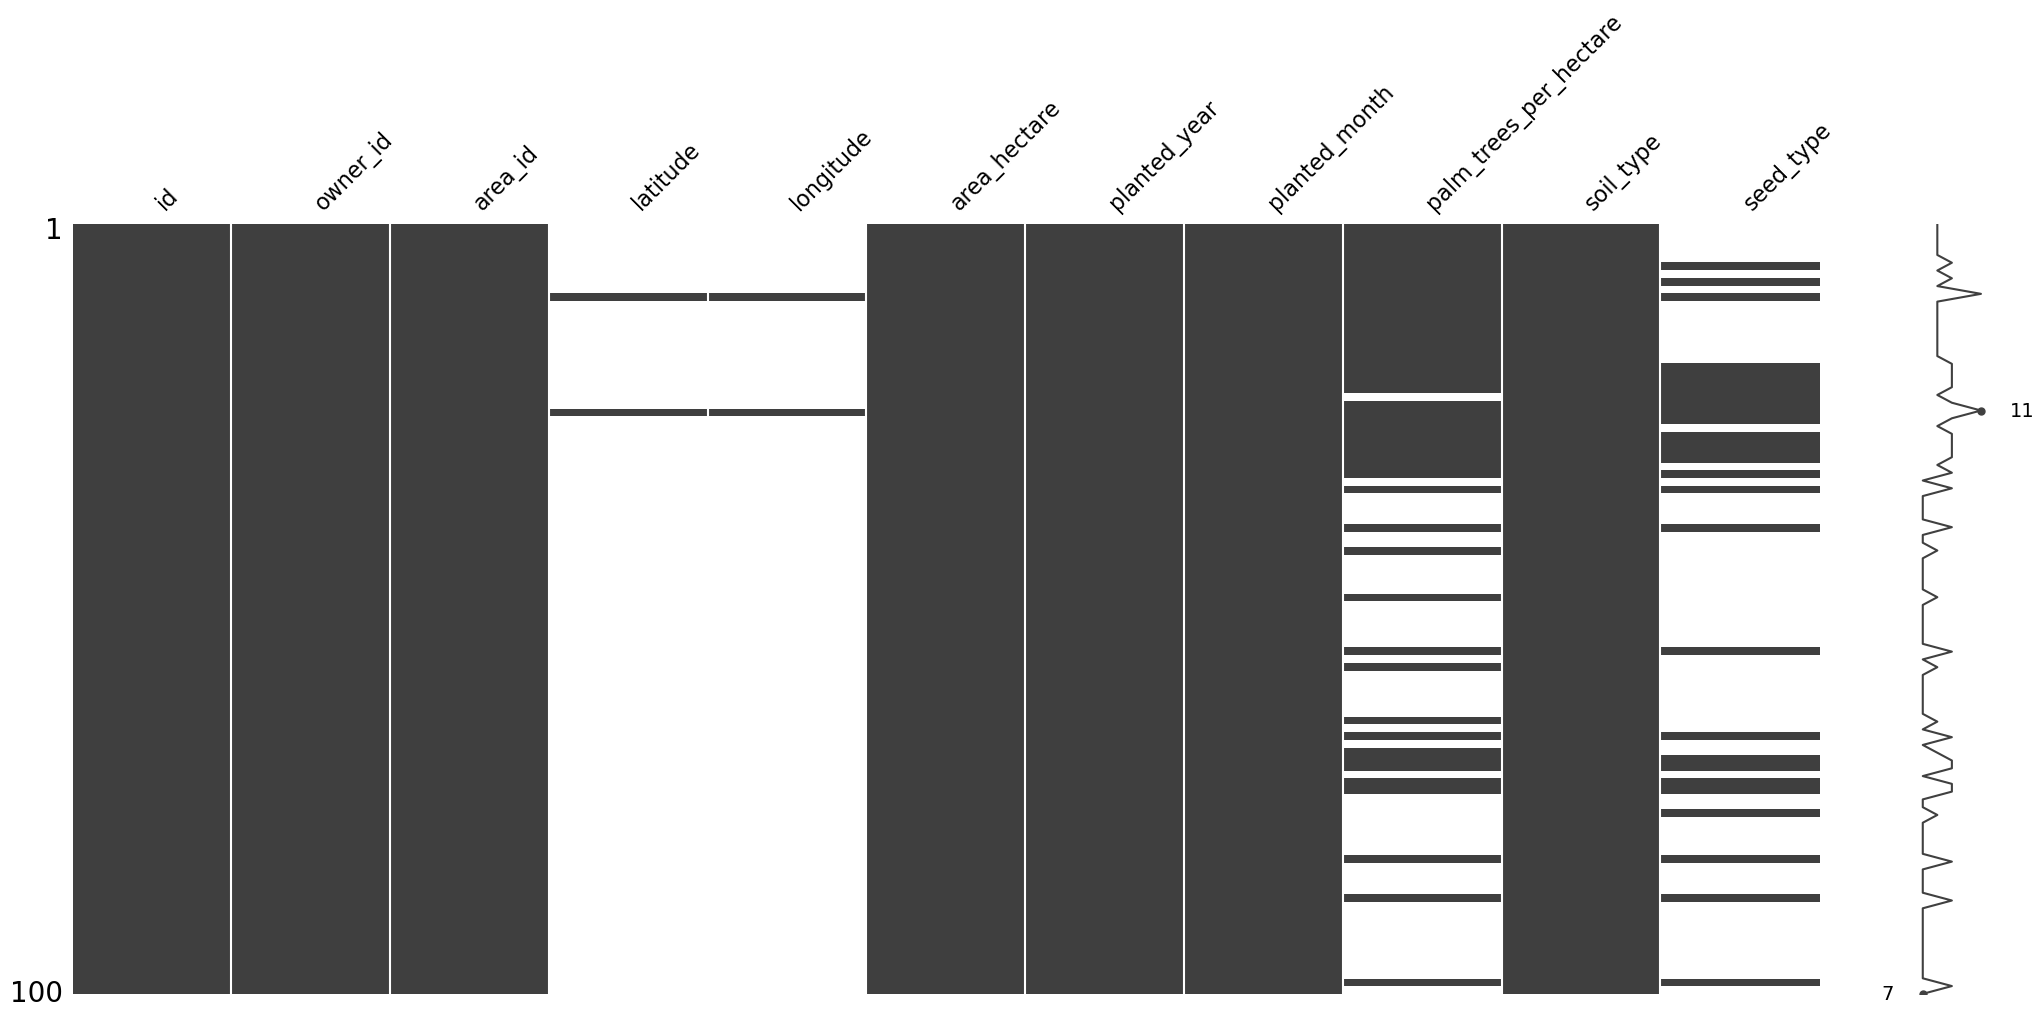

In [3270]:
# show which rows contain missing values 
msno.matrix(farm_df)
plt.show()

In [3271]:
# show null values in the product_df DataFrame
product_df.isnull().sum()

id                     0
sku                    0
type                   0
unit_of_measurement    0
name                   0
price                  0
description            0
dtype: int64

In [3272]:
# show null values in the so_df DataFrame
so_df.isnull().sum()

id                  0
user_id             0
total_item_price    0
created_at_utc0     0
dtype: int64

In [3273]:
# show null values in the soi_df DataFrame
soi_df.isnull().sum()

id                               0
sale_order_id                    0
product_id                       0
quantity                         0
price                            0
clicked_from_recommendation      0
click_timestamp                116
dtype: int64

In [3274]:
# show null values in the feedback_df DataFrame
feedback_df.isnull().sum()

feedback_id       0
sales_order_id    0
rating            0
comment           0
dtype: int64

In [3275]:
# show null values in the product_clicks_df DataFrame
product_clicks_df.isnull().sum()

prodct_clicks_id    0
product_id          0
timestamp           0
dtype: int64

In [3276]:
# show null values in the user_session_df DataFrame
user_session_df.isnull().sum()

user_session_id    0
user_id            0
session_start      0
session_end        0
dtype: int64

In [3277]:
# show the cardinality of the area_df DataFrame
area_df.nunique()

id                   46
name                 46
level_0               1
level_1              12
level_2              27
level_3              35
level_3_latitude     35
level_3_longitude    34
level_4              46
level_4_latitude     46
level_4_longitude    45
dtype: int64

In [3278]:
# show the cardinality of the farm_df DataFrame
farm_df.nunique()

id                        100
owner_id                   97
area_id                    46
latitude                    2
longitude                   2
area_hectare               21
planted_year               21
planted_month              12
palm_trees_per_hectare     18
soil_type                   3
seed_type                  10
dtype: int64

In [3279]:
# show the cardinality of the product_df DataFrame
product_df.nunique()

id                     41
sku                    41
type                    3
unit_of_measurement     2
name                   41
price                  41
description            40
dtype: int64

In [3280]:
# show the cardinality of the so_df DataFrame
so_df.nunique()

id                  100
user_id              73
total_item_price     89
created_at_utc0     100
dtype: int64

In [3281]:
# show the cardinality of the soi_df DataFrame
soi_df.nunique()

id                             116
sale_order_id                  100
product_id                      41
quantity                        31
price                           94
clicked_from_recommendation      1
click_timestamp                  0
dtype: int64

In [3282]:
# show the cardinality of the feedback_df DataFrame
feedback_df.nunique()

feedback_id       41
sales_order_id    38
rating             5
comment           41
dtype: int64

In [3283]:
# show the cardinality of the product_clicks_df DataFrame
product_clicks_df.nunique()

prodct_clicks_id    41
product_id          41
timestamp           41
dtype: int64

In [3284]:
# show the cardinality of the user_session_df DataFrame
user_session_df.nunique()

user_session_id    41
user_id            35
session_start      41
session_end        41
dtype: int64

In [3285]:
# check duplicates in the area_df DataFrame
area_df.duplicated().sum()  

0

In [3286]:
# check duplicates in the farm_df DataFrame
farm_df.duplicated().sum()  

0

In [3287]:
# check duplicates in the product_df DataFrame
product_df.duplicated().sum()

0

In [3288]:
# check duplicates in the so_df DataFrame
so_df.duplicated().sum()

0

In [3289]:
# check duplicates in the soi_df DataFrame  
soi_df.duplicated().sum()

0

In [3290]:
# check duplicates in the feedback_df DataFrame
feedback_df.duplicated().sum()

0

In [3291]:
# check duplicates in the product_clicks_df DataFrame
product_clicks_df.duplicated().sum()

0

In [3292]:
# check duplicates in the user_session_df DataFrame
user_session_df.duplicated().sum()

0

### There are no duplicated rows for each table.

array([[<Axes: title={'center': 'level_3_latitude'}>,
        <Axes: title={'center': 'level_3_longitude'}>],
       [<Axes: title={'center': 'level_4_latitude'}>,
        <Axes: title={'center': 'level_4_longitude'}>]], dtype=object)

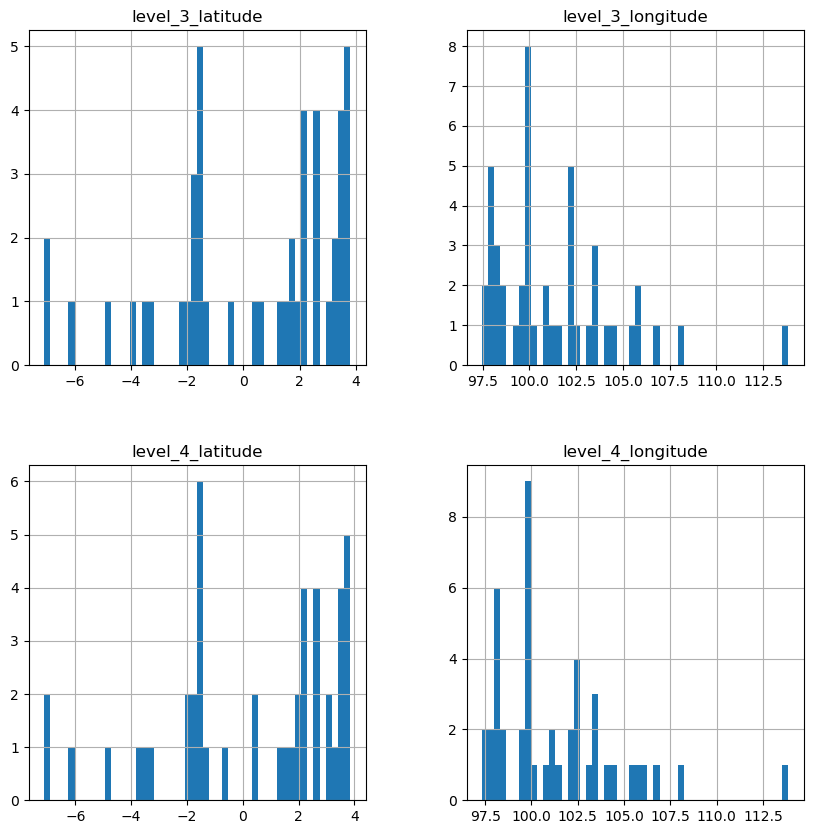

In [3293]:
# plot histogram of the area_df DataFrame
area_df.hist(figsize=(10, 10), bins=50)

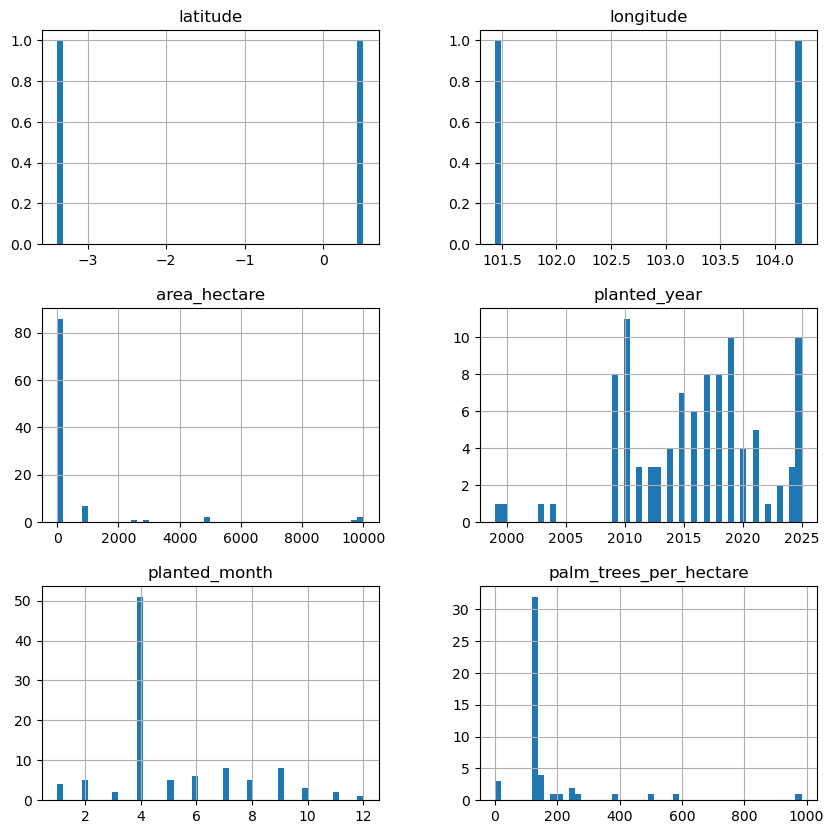

In [3294]:
# plot histogram of the farm_df DataFrame
farm_df.hist(figsize=(10, 10), bins=50)
plt.show()

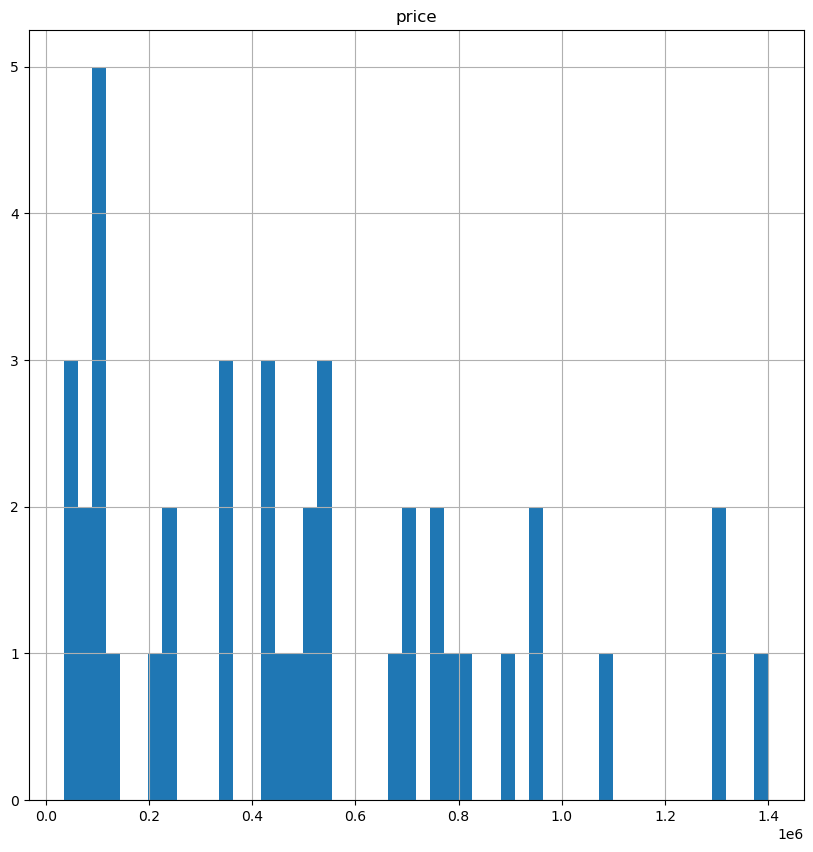

In [3295]:
# plot histogram of the product_df DataFrame
product_df.hist(figsize=(10, 10), bins=50)
plt.show()

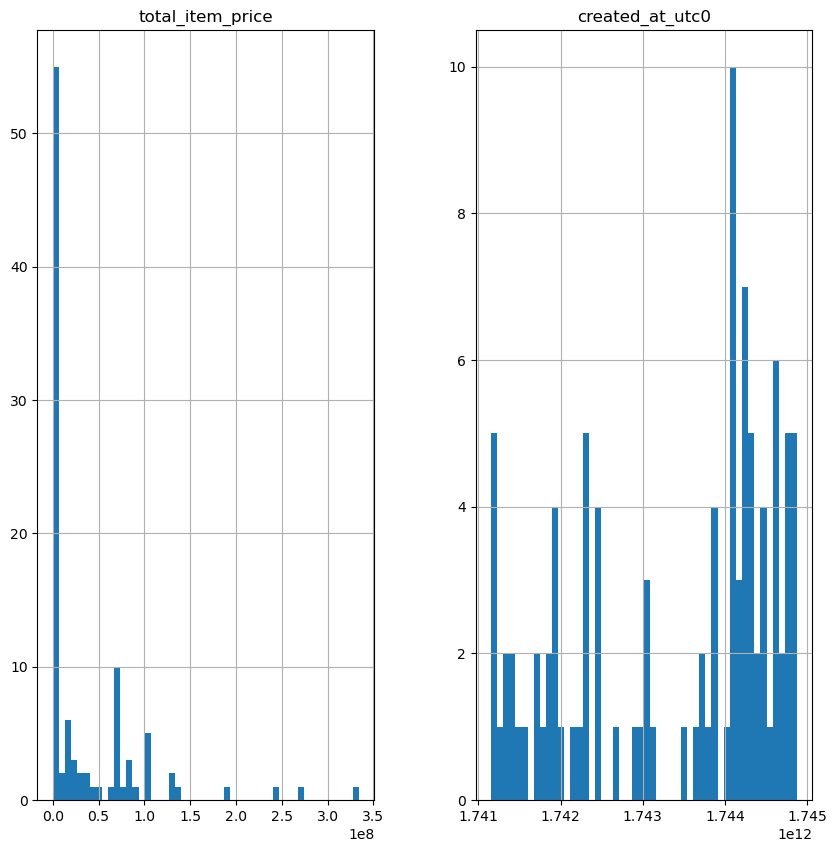

In [3296]:
# plot histogram of the so_df DataFrame
so_df.hist(figsize=(10, 10), bins=50)
plt.show()

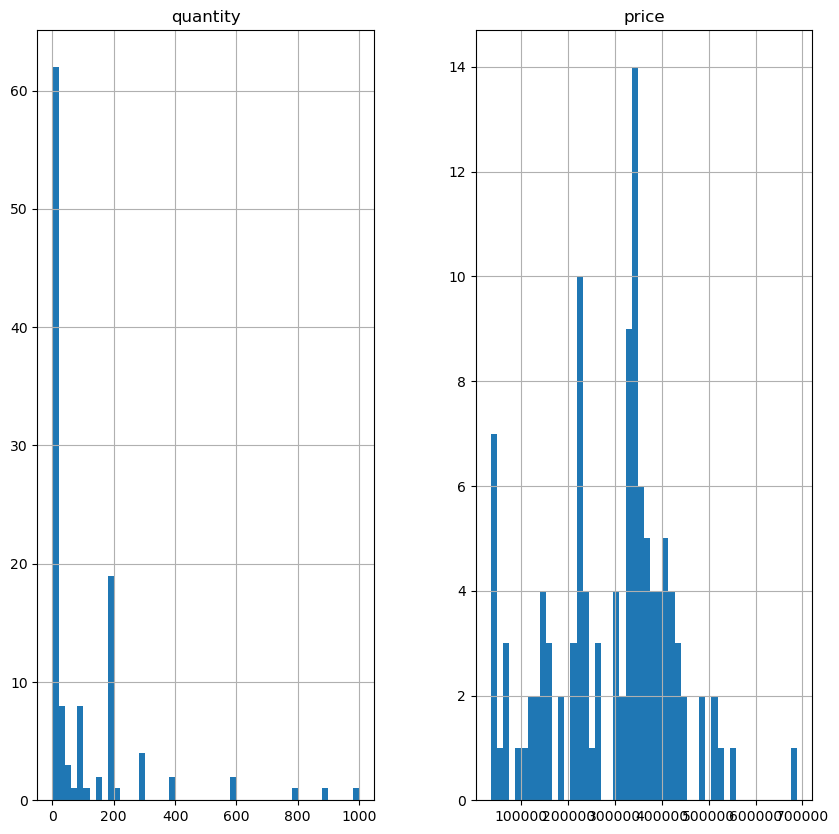

In [3297]:
# plot histogram of the soi_df DataFrame
soi_df.hist(figsize=(10, 10), bins=50)
plt.show()

### Renaming of columns for easier interpretability

In [3298]:
soi_df.columns

Index(['id', 'sale_order_id', 'product_id', 'quantity', 'price',
       'clicked_from_recommendation', 'click_timestamp'],
      dtype='object')

In [3299]:
so_df.columns

Index(['id', 'user_id', 'total_item_price', 'created_at_utc0'], dtype='object')

In [3300]:
product_df.columns

Index(['id', 'sku', 'type', 'unit_of_measurement', 'name', 'price',
       'description'],
      dtype='object')

In [3301]:
# rename product_df columns
product_df.rename(columns={'id': 'product_id', 'price': 'product_price'}, inplace=True)
product_df.columns

Index(['product_id', 'sku', 'type', 'unit_of_measurement', 'name',
       'product_price', 'description'],
      dtype='object')

In [3302]:
# rename soi_df columns
soi_df.rename(columns={'id': 'sale_order_item_id', 'price': 'sale_order_item_price'}, inplace=True)
soi_df.columns

Index(['sale_order_item_id', 'sale_order_id', 'product_id', 'quantity',
       'sale_order_item_price', 'clicked_from_recommendation',
       'click_timestamp'],
      dtype='object')

In [3303]:
# rename so_df columns
so_df.rename(columns={'id': 'sale_order_id'}, inplace=True)
so_df.columns

Index(['sale_order_id', 'user_id', 'total_item_price', 'created_at_utc0'], dtype='object')

### Merging of Dataframes

In [3304]:
merged_data = soi_df.merge(so_df, on='sale_order_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,None,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,None,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,None,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061


In [3305]:
merged_data = merged_data.merge(product_df, on='product_id')
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.</p><p><br></p><p><strong><em><u>Manfaat </u></em></strong></p><p>Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.</p><p><br></p><p><strong><em><u>Kandungan dan Spesifikasi </u></em></strong></p><p><br></p><p>Kalium oksida 60%</p><p>Bentuk / Warna: Kristal / Dominan merah</p><p><br></p><p><strong><em><u>Produk Teruji Lab?</u> </em></strong>Ya</p>"
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. <p><strong>Deskripsi</strong></p><p><br></p><p>Pupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.</p><p><br></p><p><strong>Manfaat</strong></p><p><br></p><p>Memberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.</p><p><br></p><p><strong>Kandungan dan Spesifikasi</strong></p><p><br></p><p>Fosfor pentoksida 26-28%</p><p><br></p><p><strong>Produk Teruji Lab?</strong> Ya</p>"
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,None,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,None,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"<p>Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".</p><p>Ukuran All-size (XL)</p>"
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,None,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. <p><strong><em><u>Deskripsi</u></em></strong></p><p><br></p><p>Pupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengopti

In [3306]:
def clean_html(raw_html):
    # Remove HTML tags
    clean_text = re.sub(r'<[^>]+>', '', raw_html)
    # Remove leading/trailing whitespaces and normalize spaces
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

# Apply to the 'description' column
merged_data['description'] = merged_data['description'].astype(str).apply(clean_html)

# Preview the cleaned descriptions
merged_data[['description']].head()


,description
0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
1,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
2,Topup PLN 100.000 Topup PLN 100.000
3,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
4,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"


In [3307]:
merged_data.head()

,sale_order_item_id,sale_order_id,product_id,quantity,sale_order_item_price,clicked_from_recommendation,click_timestamp,user_id,total_item_price,created_at_utc0,sku,type,unit_of_measurement,name,product_price,description
0,d4dc9c06-177e-494c-ba72-7e2954ce8ced,3ddca641-cb59-4a27-8698-cb16ff2932f2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,200,326000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya bermanfaat untuk tanaman yang membutuhkan kalium tinggi, seperti padi, jagung, dan tanaman hortikultura.Kandungan dan Spesifikasi Kalium oksida 60%Bentuk / Warna: Kristal / Dominan merahProduk Teruji Lab? Ya"
1,7eefa7db-26bf-4a8b-b207-f44a52ed0aba,3ddca641-cb59-4a27-8698-cb16ff2932f2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,200,125000.0,False,None,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,90200000.0,1744078798583,101110502101,GOODS,kg,RP Mahkota 50kg - Egypt,352688.0,"Rock Phosphate (RP) adalah salah satu sumber fosfat terbaik di dunia yang diolah secara efisien tanpa proses kimia. DeskripsiPupuk RP Mesir adalah pupuk yang diproses dari bahan baku galian yang mengandung mineral kalsium fosfat, yang berasal dari batuan yang diolah menjadi bubuk (powder) untuk digunakan langsung dalam pertanian. Pupuk ini dapat diterapkan dalam bentuk bubuk, butiran, atau granular.ManfaatMemberikan unsur fosfor alami yang dibutuhkan tanaman, mendukung perkembangan akar dan batang, meningkatkan kualitas akar serta batang tanaman, memperbaiki kemampuan tanaman dalam menyerap air dan nutrisi, serta melindungi tanaman dari serangan hama.Kandungan dan SpesifikasiFosfor pentoksida 26-28%Produk Teruji Lab? Ya"
2,e9b32dc3-4e0f-4a69-bb3d-c7f11277f97f,787bc8b7-e679-4772-be5d-af4afac9adf5,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,1,109000.0,False,None,1e75f22f-b609-4ebc-9536-4a26aef73302,109000.0,1744182202966,TUP/PLN/100,DIGITAL,,Token PLN 100.000,109000.0,Topup PLN 100.000 Topup PLN 100.000
3,86a41dec-9936-4c8f-9150-e8b367a4959f,4d47dd32-1618-4376-a846-66bcf065e173,0bd2430a-6613-442a-9d5a-11d64cb095ae,1,65000.0,False,None,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,65000.0,1742438712361,MERCH-SAWITPRO-SHIRT-02,GOODS,kg,Kaos SIBRONDOL SawitPRO size XL,100000.0,"Kaos tidak berkerah warna Putih bertuliskan ""Sibrondol SawitPRO"".Ukuran All-size (XL)"
4,61cf5f3f-2a24-4080-bc4f-50af3506479d,e5819416-6b56-4337-9271-dc2c701ac7bd,80957603-6cec-4f63-8dcd-aba6ded5cbdd,2,688750.0,False,None,49ad56f8-8d32-408f-9f88-36cad5310680,1377500.0,1744874598061,101110501601,GOODS,kg,MOP/KCL Canada Cap Mahkota 50kg,712500.0,"Pupuk MOP/KCL untuk meningkatkan Kualitas dan Kuantitas Buah. DeskripsiPupuk MOP/KCL Mahkota mengandung kalium (K2O) minimal 60% dan berguna untuk membantu meningkatkan hasil dan kualitas panen. Pupuk ini juga mengoptimalkan penyerapan unsur hara lainnya dan meningkatkan ketahanan tanaman terhadap hama dan penyakit. Penggunaan KCL sangat penting untuk tanaman tahunan yang membutuhkan kalium tinggi.Manfaat Pupuk kalium oksida (K2O) meningkatkan pertumbuhan dan hasil tanaman dengan menyuplai kalium yang penting untuk daya tahan tanaman terhadap stres, serta mendukung pembentukan buah, bunga, dan umbi. Pupuk ini juga memperbaiki kualitas hasil panen dan efisiensi penggunaan air serta nutrisi, menjadikannya

In [3308]:
# output the merged data to a CSV file to view the description data 
merged_data.to_csv('merged_data.csv', index=False)

In [3309]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sale_order_item_id           116 non-null    object 
 1   sale_order_id                116 non-null    object 
 2   product_id                   116 non-null    object 
 3   quantity                     116 non-null    int64  
 4   sale_order_item_price        116 non-null    float64
 5   clicked_from_recommendation  116 non-null    bool   
 6   click_timestamp              0 non-null      object 
 7   user_id                      116 non-null    object 
 8   total_item_price             116 non-null    float64
 9   created_at_utc0              116 non-null    int64  
 10  sku                          116 non-null    object 
 11  type                         116 non-null    object 
 12  unit_of_measurement          116 non-null    object 
 13  name                

In [3310]:
# Storing the product names in a dictionary along with their IDs
product_names = merged_data.set_index('product_id')['name'].to_dict()

num_users = merged_data['user_id'].nunique() # Number of unique users
num_products = merged_data['product_id'].nunique() # Number of unique products
print(f"Number of unique users: {num_users}")
print(f"Number of unique products: {num_products}")

# Determining the number of elements in the matrix
print("The full matrix will have:", num_users * num_products, 'elements.')

# For interactions, we will use the number of transactions to determine the number of interactions
num_interactions = len(merged_data)
print("Number of interactions (transaction):", num_interactions)

# Show the sparsity of the matrix
sparsity = (num_interactions / (num_users * num_products)) * 100
print(sparsity, '% of the matrix is filled up.')


Number of unique users: 73
Number of unique products: 41
The full matrix will have: 2993 elements.
Number of interactions (transaction): 116
3.875709989976612 % of the matrix is filled up.


In [3311]:
user_product_matrix = merged_data.pivot_table(
    index="user_id", columns="product_id", values="quantity", aggfunc="sum"
).fillna(0)

In [3312]:
# Count number of unique products purchased per user
top_users_unique_products = merged_data.groupby('user_id')['product_id'].nunique().sort_values(ascending=False).head(15)

# Display the result
print("Top 15 Users by Number of Unique Products Purchased:")
print(top_users_unique_products)

Top 15 Users by Number of Unique Products Purchased:
user_id
9419bea1-d06e-4c66-ad5f-f395aeb3af29    7
7a341d40-7166-46d4-b37f-be9a9ecec7f7    4
ebd171b6-81b8-43f2-afa2-67c5db13845a    4
49ad56f8-8d32-408f-9f88-36cad5310680    4
9c605d36-9c37-4f1e-bac1-c87146fae1f0    3
444d489c-eabd-4e37-b21b-d11ebeb28f9b    3
e30a4901-7558-4605-9d0d-980adaaa01c2    2
8d2391db-c0d3-4a6a-8ff7-78339f8e68c0    2
bc58410c-c5c7-474f-b8ee-8ea16bb3a1b5    2
438c0b35-30eb-4a57-9577-0f7c13d81eb7    2
8c5c639f-2c15-4b35-8ee3-f1302b3c82a6    2
eae0adf5-7428-4ad8-a4d8-368dd5543992    2
13f5223e-f04a-4fa8-9ef2-cf36060f0d6d    2
0d31385d-79be-436f-9890-69104741bf26    2
e4d68529-9d3c-4db3-bc55-cc3bc3ead00f    1
Name: product_id, dtype: int64


#### Only 14 users have made more than 1 purchase

## Collaborative Filtering

## K-means clustering

In [3313]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors) # think of this as a lookup table for the input.
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors) # think of this as a lookup table for the input.
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        # matrix multiplication
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users)*self.item_factors(items)).sum(1)

    def predict(self, user, item):
        return self.forward(user, item)

In [3314]:
# Creating the dataloader (necessary for PyTorch)
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader  # Package that helps transform your data to machine learning readiness
import torch

# Custom Dataset Loader for merged_data
class Loader(Dataset):
    def __init__(self, merged_data):
        self.ratings = merged_data.copy()
        
        # Extract all unique user IDs and product IDs
        users = self.ratings['user_id'].unique()
        products = self.ratings['product_id'].unique()
        
        # --- Producing new continuous IDs for users and products ---
        
        # Unique values : index
        self.userid2idx = {o: i for i, o in enumerate(users)}
        self.productid2idx = {o: i for i, o in enumerate(products)}
        
        # Obtained continuous ID for users and products
        self.idx2userid = {i: o for o, i in self.userid2idx.items()}
        self.idx2productid = {i: o for o, i in self.productid2idx.items()}
        
        # Map user_id and product_id to their continuous indices
        self.ratings['user_id'] = self.ratings['user_id'].apply(lambda x: self.userid2idx[x])
        self.ratings['product_id'] = self.ratings['product_id'].apply(lambda x: self.productid2idx[x])
        
        # Prepare input (x) and target (y) tensors
        self.x = self.ratings[['user_id', 'product_id']].values
        self.y = self.ratings['quantity'].values  
        self.x, self.y = torch.tensor(self.x, dtype=torch.long), torch.tensor(self.y, dtype=torch.float)  # Transform to tensors

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

# Example Usage
dataset = Loader(merged_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  # Adjust batch_size as needed

# Iterate through the DataLoader
for batch in dataloader:
    x_batch, y_batch = batch
    print("Input (x):", x_batch)
    print("Target (y):", y_batch)
    break  

Input (x): tensor([[24, 18],
        [ 9,  7],
        [26, 20],
        [28, 22],
        [28, 23],
        [13,  4],
        [39, 25],
        [38,  0],
        [65, 38],
        [59,  1],
        [ 1,  2],
        [58, 37],
        [ 3,  0],
        [11,  9],
        [71, 30],
        [23, 17],
        [11,  9],
        [17, 26],
        [54, 15],
        [41,  9],
        [19, 13],
        [ 6,  1],
        [12, 10],
        [48, 30],
        [ 3,  5],
        [44, 30],
        [55,  0],
        [ 4,  4],
        [24, 18],
        [24, 26],
        [ 3,  8],
        [ 3,  8]])
Target (y): tensor([300.,   1.,   7.,   2.,   2.,   1.,   1., 100.,   1.,   2.,   1.,  55.,
          2., 200.,   7.,  32., 160., 200.,   5.,  40.,  90.,   1.,   1.,  75.,
          1.,  25.,   9., 100., 300., 200.,   1.,   1.])


In [3315]:
# Training setup
num_epochs = 128
cuda = torch.cuda.is_available()

print("Is running on GPU:", cuda)

# Number of users and items (replace with actual values from your data)
n_users = merged_data['user_id'].nunique()
n_items = merged_data['product_id'].nunique()

# Initialize the model
model = MatrixFactorization(n_users, n_items, n_factors=8)
print(model)

# Print model parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# Move model to GPU if available
if cuda:
    model = model.cuda()

# Define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Prepare the data
train_set = Loader(merged_data)  # Pass merged_data as an argument
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)  # Adjust batch_size as needed

# Training loop
for it in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    # Print average loss for the epoch
    if len(losses) > 0:
        print(f"Epoch {it+1}/{num_epochs}, Loss: {sum(losses) / len(losses)}")
    else:
        print(f"Epoch {it+1}/{num_epochs}, No losses recorded.")

Is running on GPU: False
MatrixFactorization(
  (user_factors): Embedding(73, 8)
  (item_factors): Embedding(41, 8)
)
user_factors.weight tensor([[4.3847e-03, 4.3619e-02, 1.6059e-02, 2.7308e-02, 2.3113e-02, 4.5714e-02,
         3.3998e-02, 1.3439e-02],
        [2.2654e-02, 4.1643e-03, 1.1097e-02, 2.3611e-02, 1.3226e-02, 2.8649e-03,
         1.7204e-02, 3.4296e-02],
        [5.6371e-03, 2.1453e-02, 2.2854e-02, 9.1601e-04, 4.9824e-03, 4.2039e-03,
         2.2590e-02, 8.7316e-03],
        [4.2632e-02, 4.3391e-02, 3.0747e-02, 1.7980e-02, 6.9004e-03, 1.8456e-02,
         1.4920e-02, 3.6928e-02],
        [4.0389e-02, 1.5488e-02, 1.1696e-02, 3.1213e-02, 4.0164e-02, 4.2147e-02,
         4.6306e-02, 4.7769e-02],
        [4.0044e-02, 8.2379e-04, 3.0759e-02, 2.1885e-02, 2.3978e-02, 2.3051e-02,
         1.5546e-02, 8.5376e-03],
        [4.5741e-02, 5.2928e-03, 3.6467e-02, 3.4984e-02, 2.8742e-03, 1.1785e-02,
         3.5979e-02, 4.5934e-03],
        [2.2014e-02, 5.7831e-03, 4.0517e-02, 2.8060e-02, 

C:\Users\user\AppData\Local\Temp\ipykernel_16588\4062156335.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for it in tqdm(range(num_epochs)):


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1/128, Loss: 41551.2578125
Epoch 2/128, Loss: 41551.171875
Epoch 3/128, Loss: 41551.08203125
Epoch 4/128, Loss: 41550.98828125
Epoch 5/128, Loss: 41550.88671875
Epoch 6/128, Loss: 41550.78515625
Epoch 7/128, Loss: 41550.68359375
Epoch 8/128, Loss: 41550.57421875
Epoch 9/128, Loss: 41550.4609375
Epoch 10/128, Loss: 41550.34375
Epoch 11/128, Loss: 41550.22265625
Epoch 12/128, Loss: 41550.09375
Epoch 13/128, Loss: 41549.96875
Epoch 14/128, Loss: 41549.83984375
Epoch 15/128, Loss: 41549.703125
Epoch 16/128, Loss: 41549.55859375
Epoch 17/128, Loss: 41549.41796875
Epoch 18/128, Loss: 41549.265625
Epoch 19/128, Loss: 41549.1171875
Epoch 20/128, Loss: 41548.953125
Epoch 21/128, Loss: 41548.7890625
Epoch 22/128, Loss: 41548.62109375
Epoch 23/128, Loss: 41548.453125
Epoch 24/128, Loss: 41548.27734375
Epoch 25/128, Loss: 41548.0859375
Epoch 26/128, Loss: 41547.90234375
Epoch 27/128, Loss: 41547.70703125
Epoch 28/128, Loss: 41547.50390625
Epoch 29/128, Loss: 41547.296875
Epoch 30/128, Loss: 

In [3316]:
# By training the model, we will have tuned latent factors for movies and users.
c = 0
uw = 0
iw = 0 
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
        if c == 0:
          uw = param.data
          c +=1
        else:
          iw = param.data
        #print('param_data', param_data)

user_factors.weight tensor([[0.1812, 0.2116, 0.1870, 0.2014, 0.1854, 0.2080, 0.2041, 0.1818],
        [0.1895, 0.1786, 0.1665, 0.1827, 0.1684, 0.1604, 0.1753, 0.2002],
        [0.1800, 0.1971, 0.1821, 0.1646, 0.1799, 0.1722, 0.1919, 0.1827],
        [0.2098, 0.2080, 0.1976, 0.1841, 0.1705, 0.1803, 0.1757, 0.2073],
        [0.2131, 0.1779, 0.1730, 0.1914, 0.2165, 0.2196, 0.2186, 0.2193],
        [0.2137, 0.1629, 0.2062, 0.2010, 0.1856, 0.2026, 0.1825, 0.1769],
        [0.2227, 0.1594, 0.2126, 0.2036, 0.1576, 0.1673, 0.2128, 0.1600],
        [0.2031, 0.1650, 0.2208, 0.2011, 0.1645, 0.1930, 0.2182, 0.1991],
        [0.1976, 0.1905, 0.2018, 0.2188, 0.1664, 0.1848, 0.1658, 0.1588],
        [0.2114, 0.1851, 0.2022, 0.1948, 0.1813, 0.1993, 0.1989, 0.1696],
        [0.2115, 0.1726, 0.1986, 0.1981, 0.2155, 0.2115, 0.1976, 0.2033],
        [0.1685, 0.1833, 0.1915, 0.2007, 0.1940, 0.1923, 0.1880, 0.1789],
        [0.2043, 0.1631, 0.1600, 0.1863, 0.2056, 0.1916, 0.1731, 0.1770],
        [0.1950, 0

In [3317]:
trained_product_embeddings = model.item_factors.weight.data.cpu().numpy()

In [3318]:
len(trained_product_embeddings) # unique product factor weights

41

In [3319]:
from sklearn.cluster import KMeans
# Fit the clusters based on the movie weights
kmeans = KMeans(n_clusters=10, random_state=0).fit(trained_product_embeddings)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [3320]:
for cluster in range(10):
    print("Cluster #{}".format(cluster))
    products = []
    # Find product indices belonging to the current cluster
    for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
        prod_id = train_set.idx2productid[prod_idx]
        # Check how many times this product has been purchased
        purchase_count = len(merged_data.loc[merged_data['product_id'] == prod_id])
        products.append((product_names[prod_id], purchase_count))
    # Sort products by purchase count in descending order and print top 10
    for prod in sorted(products, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", prod[0])

Cluster #0
	 NPK Phonska Plus 15-15-15 25kg
	 RP Cap Daun 50Kg
Cluster #1
	 MOP/KCL Canada Cap Mahkota 50kg
	 Dolomite M-100 50kg
	 Token PLN 100.000
	 Kaos SIBRONDOL SawitPRO size XL
	 Meroke TSP 50kg
	 NPK Mahkota 12-12-17-2 TE 50kg
	 Bibit Topaz Siap Tanam
	 Mahkota ZA 50kg
Cluster #2
	 Token PLN 200.000
	 Topi SawitPRO Hijau
	 DMA 6 825 SL 400ml
	 Meroke Korn Kali B (KKB) 50kg
Cluster #3
	 NPK DGW 13-8-27-4 TE 50kg
	 TSP China Cap Daun 50kg
	 Bablass 490 SL - 1 Liter
	 NPK Sawit 13-8-27-4 0.5 B Pak Tani 50kg
Cluster #4
	 NPK Mahkota 13-8-27-4 0.5 B 50kg
	 Pupuk SawitPRO 20kg + Abu Janjang 40kg
	 Urea Nitrea 46% N 50kg - Granul
	 Marxone 300 SL - 5 Liter
	 Bom Up 520 SL - 5 Liter
Cluster #5
	 Urea Nitrea 46% N 50kg
	 Meroke SS - AMMOPHOS 50kg
	 Kieserite Mahkota 50kg
Cluster #6
	 Borate Mahkota - 25kg
	 Bablass 490 SL - 5 Liter
	 NPK DGW 13-6-27 50kg
	 Paket Laporan Pengiriman
	 Batara 135 SL - 1 Liter
Cluster #7
	 Petro ZA Plus 50kg
	 Kieserite SoluMAG-G 50kg
	 PRIMASTAR 300/100 SL

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

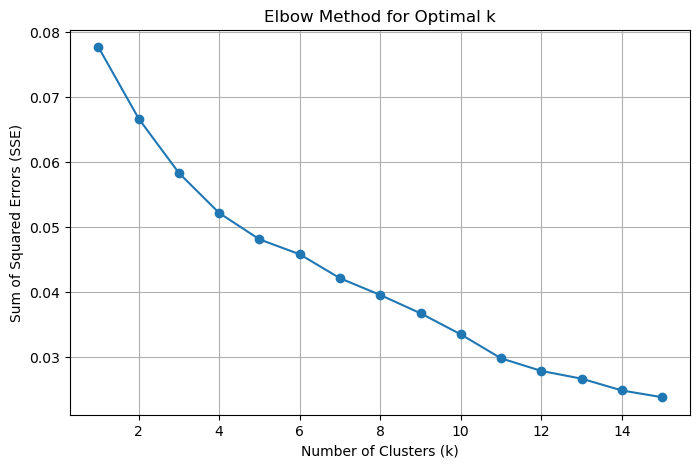

In [3321]:
# List to store the SSE for each k
sse = []

# Range of cluster values to test 
k_range = range(1, 16)

# Compute KMeans and SSE for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(trained_product_embeddings)
    sse.append(kmeans.inertia_)  # inertia_ is the SSE

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


In [3322]:
from sklearn.cluster import KMeans

sse = {}
k_values = range(1, 16)  # You can change the upper limit as needed

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(trained_product_embeddings)
    sse[k] = kmeans.inertia_  # inertia_ is the SSE for that k

# Print the SSE scores
print("SSE Scores for each k:")
for k, score in sse.items():
    print(f"k = {k}: SSE = {score:.2f}")


SSE Scores for each k:
k = 1: SSE = 0.08
k = 2: SSE = 0.07
k = 3: SSE = 0.06
k = 4: SSE = 0.05
k = 5: SSE = 0.05
k = 6: SSE = 0.05
k = 7: SSE = 0.04
k = 8: SSE = 0.04
k = 9: SSE = 0.04
k = 10: SSE = 0.03
k = 11: SSE = 0.03
k = 12: SSE = 0.03
k = 13: SSE = 0.03
k = 14: SSE = 0.02
k = 15: SSE = 0.02


c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

In [3323]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(trained_product_embeddings)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [3324]:
for cluster in range(6):
    print("Cluster #{}".format(cluster))
    products = []
    # Find product indices belonging to the current cluster
    for prod_idx in np.where(kmeans.labels_ == cluster)[0]:
        prod_id = train_set.idx2productid[prod_idx]
        # Check how many times this product has been purchased
        purchase_count = len(merged_data.loc[merged_data['product_id'] == prod_id])
        products.append((product_names[prod_id], purchase_count))
    # Sort products by purchase count in descending order and print top 10
    for prod in sorted(products, key=lambda tup: tup[1], reverse=True)[:10]:
        print("\t", prod[0])

Cluster #0
	 Pupuk SawitPRO 50kg + Abu Janjang 40kg
	 Urea Nitrea 46% N 50kg - Granul
	 RP Cap Daun 50Kg
	 ZA Cap Daun 50Kg
	 Dolomit Super Inti M-100 50kg
Cluster #1
	 MOP/KCL Canada Cap Mahkota 50kg
	 NPK Mahkota 13-8-27-4 0.5 B 50kg
	 Pupuk SawitPRO 20kg + Abu Janjang 40kg
	 Pupuk SawitPRO 50kg
	 Dolomite M-100 50kg
	 Kaos SIBRONDOL SawitPRO size XL
	 Meroke TSP 50kg
	 NPK Mahkota 12-12-17-2 TE 50kg
	 Bibit Topaz Siap Tanam
	 Kapur Pertanian Kebomas 50 Kg
Cluster #2
	 Urea Nitrea 46% N 50kg
	 NPK DGW 13-8-27-4 TE 50kg
	 TSP China Cap Daun 50kg
	 Token PLN 100.000
	 Bablass 490 SL - 1 Liter
	 Meroke SS - AMMOPHOS 50kg
	 Mahkota ZA 50kg
	 Kieserite Mahkota 50kg
Cluster #3
	 NPK Phonska Plus 15-15-15 25kg
	 Bablass 490 SL - 5 Liter
	 Token PLN 200.000
	 NPK DGW 13-6-27 50kg
	 Paket Laporan Pengiriman
	 NPK Sawit 13-8-27-4 0.5 B Pak Tani 50kg
	 Topi SawitPRO Hijau
	 DMA 6 825 SL 400ml
	 Meroke Korn Kali B (KKB) 50kg
	 Bom Up 520 SL - 5 Liter
Cluster #4
	 Borate Mahkota - 25kg
	 Petro ZA

## User-Based Collaborative Filtering using Truncated Singular Value Decomposition (TruncatedSVD)

In [3325]:
# Create user-product matrix
user_product_matrix = merged_data.pivot_table(index='user_id', columns='product_id', values='quantity', fill_value=0)

# Matrix factorization using TruncatedSVD
svd = TruncatedSVD(n_components=10, random_state=42)
matrix_svd = svd.fit_transform(user_product_matrix)
print(svd.explained_variance_ratio_.sum())

# Compute cosine similarity between users
user_similarity = cosine_similarity(matrix_svd)

# Create a DataFrame of similarities
user_similarity_df = pd.DataFrame(user_similarity, index=user_product_matrix.index, columns=user_product_matrix.index)
user_similarity_df.head()

0.9855573639582237


user_id,02b2724f-0227-4c94-a7a0-8cf37f7aee70,05dfbe78-f1f3-486d-8bc8-91ef41b3ae78,05ebeca1-5a73-46ec-88fc-323b29d468cc,0600fab5-173c-4333-b3c3-c18b37148acf,0baaaa63-a05f-492d-8f87-9532257d85f9,0d31385d-79be-436f-9890-69104741bf26,10012ced-8aef-44ed-b6c0-eae920c6e28e,139fe063-7276-4c10-8926-2a4bb0005e6c,13f5223e-f04a-4fa8-9ef2-cf36060f0d6d,1e62475b-0909-420f-a394-afe02d77ff5e,1e75f22f-b609-4ebc-9536-4a26aef73302,1f9c8b9d-1785-4247-9902-f3bf61fc5b70,231e825c-16af-4695-bda8-91deb60777e5,2c58c0d7-2214-4747-9ca3-f4f4b75880f9,344963f8-9a3a-4de3-b3a9-c8716fa37c0e,34e01958-7a5d-4016-bb9a-e36d87ed3bf6,38969042-aa78-4066-b83a-22756b4191ba,4175d8f7-3242-46cb-9750-25b9804f5177,41bec98e-b466-496b-acf2-e993389ac42b,438c0b35-30eb-4a57-9577-0f7c13d81eb7,43999ff4-01db-4bc6-b1fe-4427a918b294,444d489c-eabd-4e37-b21b-d11ebeb28f9b,468556ca-994d-40aa-9c44-859d8e445a57,49ad56f8-8d32-408f-9f88-36cad5310680,59707eb3-194b-42f6-a2be-5c4ca9eeb23a,5ec10eea-f7ab-4db6-b7b8-142845767460,67050d7d-04e8-4fc3-a2eb-ac1b533dd222,6920e798-c041-4c93-88c2-fa188ec4daa0,695e066a-270e-461d-9f04-7893b57603eb,733b3de2-8852-4032-80cb-c785a1b3bb41,74cd1768-c0aa-4a1d-8516-c8323f71b12e,7a341d40-7166-46d4-b37f-be9a9ecec7f7,804b949e-a2ea-4600-b563-5344410f852d,85613812-25e3-495e-b5d8-fab227893c83,87873f2e-bc4f-47da-aca7-5f0b17cd5ef5,8b621082-7337-4d55-a2ff-e3518797094c,8c5c639f-2c15-4b35-8ee3-f1302b3c82a6,8c89bfd1-64bf-484a-9860-bab339f48261,8d2391db-c0d3-4a6a-8ff7-78339f8e68c0,9152143a-2ad6-4a45-a0d0-e2a444bbde3d,917278db-9719-4988-a151-237f4fc74b9d,9419bea1-d06e-4c66-ad5f-f395aeb3af29,94c969e0-729a-4b93-9ace-7182276f4ae8,972601a1-d233-4387-8b88-fd2611506d1f,9c605d36-9c37-4f1e-bac1-c87146fae1f0,9e7d6e43-d3b9-4c94-94a2-0029a3fa43cc,a2cd71be-a882-4382-a999-e2fecd1ecba4,a465b71c-48f2-4ed6-9a17-469ebcdc4e66,b00e203a-271b-413e-b6ac-a850363339bd,b93b8e2b-ffa7-4e29-bbf1-c90cce4c0962,bc58410c-c5c7-474f-b8ee-8ea16bb3a1b5,be46ecdc-6291-4848-8014-2f910cb3e896,bf5af726-2973-481e-8b7a-3d4dd44a9376,c336fefa-41b7-40cc-95d2-f5a0220f700c,c459e2e2-3f03-4ae5-a01f-96958b5b607d,c51ed79a-e737-40d2-9846-1e842ee3e9a9,c84be8f7-1081-46ea-82c5-e4dedda9e39d,c90e42f6-b841-4267-8c6c-6c0e2fa14911,cddfaf43-dc19-437c-aa34-fac8addcbfb4,d27f2ad2-07c5-4b9f-a40b-26d324547947,d428b703-9683-4789-935d-d6a247db6ac7,d4379720-241d-4186-b07c-e85c05bb143c,d81b9980-35d6-4701-8692-03b5b34e0243,e30a4901-7558-4605-9d0d-980adaaa01c2,e4d68529-9d3c-4db3-bc55-cc3bc3ead00f,e5bd865a-1507-46fd-bcd7-62fe1d8d50ec,eae0adf5-7428-4ad8-a4d8-368dd5543992,eaeb96f7-eedc-4613-a2a6-2ac88902ec62,ebd171b6-81b8-43f2-afa2-67c5db13845a,ec22c8d8-8647-4c0d-8ace-63be2bbe57a0,ecc640f2-61b3-41e4-b2c5-5cd2421da2d8,eddc7f2d-9b65-477d-8014-65a332d93f37,f5a6f92f-7b88-4ccb-896c-0152c50ce4d1
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02b2724f-0227-4c94-a7a0-8cf37f7aee70,8.639358e-33,-9.082111e-17,-1.305846e-18,-3.955925e-18,6.539597e-19,1.227017e-17,-1.305846e-18,4.285153e-18,-2.723337e-19,9.207073e-19,-1.329364e-33,-7.241179e-32,6.894288e-38,3.709991e-39,-1.546290e-33,-1.098550e-17,4.285153e-18,-3.955925e-18,-1.067712e-17,1.807491e-33,-3.955925e-18,4.307643e-18,-9.171729e-17,-1.309599e-18,-4.655898e-18,-9.171729e-17,-7.932494e-21,-1.305846e-18,-9.171729e-17,-1.305846e-18,-1.067712e-17,6.539188e-18,7.936409e-17,2.488622e-42,6.539597e-19,-6.116581e-17,-9.171729e-17,1.024139e-42,-1.098548e-17,-9.169675e-17,-9.086921e-17,8.052233e-19,2.550262e-33,-3.955925e-18,-2.426968e-18,1.896913e-18,-1.034454e-31,-1.305846e-18,-2.068908e-32,-1.232205e-36,6.539597e-19,9.207073e-19,6.539597e-19,9.207073e-19,-1.305846e-18,3.615702e-18,-9.171729e-17,-6.116581e-17,-1.137900e-31,9.207073e-19,2.481762e-34,7.750344e-38,-9.171729e-17,-8.857125e-17,-3.955925e-18,1.727872e-33,-3.651616e-18,-1.305846e-18,-2.513544e-18,9.207073e-19,1.364969e-32,2.914125e-18,-1.098550e-17
05dfbe78-f1f3-486d-8bc8-91ef41b3ae78,-9.082111e-17,1.000000e+00,5.807470e-04,-1.510332e-04,-1.157108e-01,-9.343691e-04,5.807470e-04,-7.095259e-03,-4.809012e-03,-7.382003e-03,1.58049

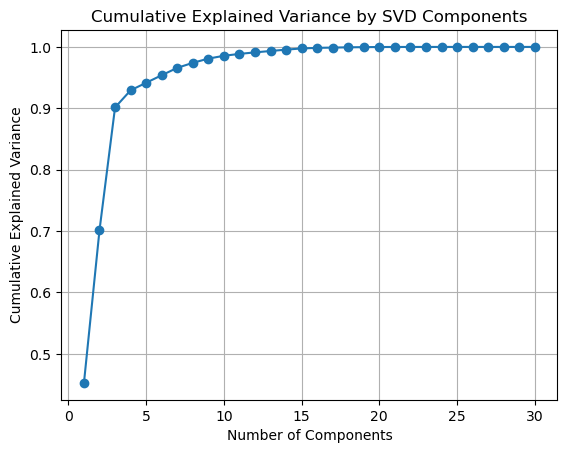

In [3326]:
svd = TruncatedSVD(n_components=30)
svd.fit(user_product_matrix)

plt.plot(range(1, 31), svd.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by SVD Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [3327]:
def recommend_products(user_id, user_product_matrix, user_similarity_df, top_n=10, top_k_similar_users=10):
    # Find top-k similar users (excluding self)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:top_k_similar_users + 1]

    print(f"\nTop {top_k_similar_users} similar users to {user_id} with cosine similarity:")
    for uid, score in similar_users.items():
        print(f"User: {uid} — Similarity: {score:.4f}")

    # Products already bought by the target user
    already_bought = user_product_matrix.loc[user_id]
    already_bought_products = already_bought[already_bought > 0].index.tolist()

    # Collect products from similar users
    product_scores = {}

    for sim_user_id, similarity in similar_users.items():
        sim_user_products = user_product_matrix.loc[sim_user_id]
        for product_id, qty in sim_user_products.items():
            if qty > 0 and product_id not in already_bought_products:
                if product_id not in product_scores:
                    product_scores[product_id] = []
                product_scores[product_id].append(similarity)

    # Average similarity per product
    avg_similarity_scores = {pid: sum(scores) / len(scores) for pid, scores in product_scores.items()}
    sorted_products = sorted(avg_similarity_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    print(f"\nProducts already bought by user {user_id}:")
    bought_product_names = [
        merged_data[merged_data['product_id'] == pid]['name'].iloc[0]
        if not merged_data[merged_data['product_id'] == pid]['name'].empty else "Unknown"
        for pid in already_bought_products
    ]
    print(', '.join(bought_product_names) if bought_product_names else "No purchases found.")
    
    # Display similar users' purchases
    print(f"\nProducts bought by similar users (not necessarily recommended for {user_id}):")
    for uid in similar_users.index:
        bought_product_ids = user_product_matrix.loc[uid][user_product_matrix.loc[uid] > 0].index.tolist()
        bought_product_names = [merged_data[merged_data['product_id'] == pid]['name'].iloc[0] for pid in bought_product_ids]
        print(f"User {uid} bought: {', '.join(bought_product_names)}")

    # Display recommendations
    print(f"\nTop recommended products for user {user_id} (based on user similarity):\n")
    for product_id, avg_sim in sorted_products:
        product_name = merged_data[merged_data['product_id'] == product_id]['name'].iloc[0]
        print(f"{product_name} — Avg Similarity of Recommenders: {avg_sim:.4f}")

    return sorted_products, similar_users

# Example usage
user_id = '13f5223e-f04a-4fa8-9ef2-cf36060f0d6d'
recommendations, similar_users = recommend_products(user_id, user_product_matrix, user_similarity_df)




Top 10 similar users to 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d with cosine similarity:
User: 9419bea1-d06e-4c66-ad5f-f395aeb3af29 — Similarity: 0.9768
User: 9e7d6e43-d3b9-4c94-94a2-0029a3fa43cc — Similarity: 0.7078
User: 6920e798-c041-4c93-88c2-fa188ec4daa0 — Similarity: 0.7071
User: a465b71c-48f2-4ed6-9a17-469ebcdc4e66 — Similarity: 0.7071
User: 733b3de2-8852-4032-80cb-c785a1b3bb41 — Similarity: 0.7071
User: c459e2e2-3f03-4ae5-a01f-96958b5b607d — Similarity: 0.7071
User: 05ebeca1-5a73-46ec-88fc-323b29d468cc — Similarity: 0.7071
User: 10012ced-8aef-44ed-b6c0-eae920c6e28e — Similarity: 0.7071
User: eaeb96f7-eedc-4613-a2a6-2ac88902ec62 — Similarity: 0.7071
User: 1e62475b-0909-420f-a394-afe02d77ff5e — Similarity: 0.7071

Products already bought by user 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d:
MOP/KCL Canada Cap Mahkota 50kg, RP Mahkota 50kg - Egypt

Products bought by similar users (not necessarily recommended for 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d):
User 9419bea1-d06e-4c66-ad5f-f395aeb3af2

## Item-Based Collaborative Filtering

In [3328]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Create user-product matrix
user_product_matrix = merged_data.pivot_table(index='user_id', columns='product_id', values='quantity', fill_value=0)

# Compute cosine similarity between items
item_similarity = cosine_similarity(user_product_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_product_matrix.columns, columns=user_product_matrix.columns)

def recommend_similar_items(product_id, item_similarity_df, merged_data, top_n=10):
    if product_id not in item_similarity_df.index:
        print(f"Product ID {product_id} not found.")
        return []

    similar_items = item_similarity_df[product_id].sort_values(ascending=False)[1:top_n+1]

    print(f"\nTop {top_n} items similar to Product ID: {product_id}")
    for pid, score in similar_items.items():
        name = merged_data[merged_data['product_id'] == pid]['name'].iloc[0] \
            if not merged_data[merged_data['product_id'] == pid]['name'].empty else "Unknown"
        print(f"{name} — Similarity: {score:.4f}")

    return pd.DataFrame({
        'product_id': similar_items.index,
        'similarity': similar_items.values
    })

# Example usage
product_id = '80957603-6cec-4f63-8dcd-aba6ded5cbdd'  # replace with actual product_id
recommendations_df = recommend_similar_items(product_id, item_similarity_df, merged_data)



Top 10 items similar to Product ID: 80957603-6cec-4f63-8dcd-aba6ded5cbdd
NPK Mahkota 13-8-27-4 0.5 B 50kg — Similarity: 0.3659
TSP China Cap Daun 50kg — Similarity: 0.1618
RP Mahkota 50kg - Egypt — Similarity: 0.1615
Urea Nitrea 46% N 50kg — Similarity: 0.1301
Meroke TSP 50kg — Similarity: 0.0971
Borate Mahkota - 25kg — Similarity: 0.0762
Kieserite SoluMAG-G 50kg — Similarity: 0.0024
Petro ZA Plus 50kg — Similarity: 0.0022
Pupuk SawitPRO 50kg — Similarity: 0.0003
RP Cap Daun 50Kg — Similarity: 0.0001


## Time-based Collaborative Filtering (Recommend hot products used by farmers recently)

## Content-based Filtering

## Product Description Matching (NLP and TF-IDF)

In [3329]:
# Combine name and description for TF-IDF input
merged_data['text'] = merged_data['name'] + " " + merged_data['description'].fillna("")

# Deduplicated product list
product_titles = merged_data[['product_id', 'name', 'description', 'text']].drop_duplicates().reset_index(drop=True)

# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_titles['text'])

# Cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Index mapping: product name → TF-IDF matrix index
indices = pd.Series(product_titles.index, index=product_titles['name']).drop_duplicates()

def get_user_purchased_products(user_id):
    return merged_data[merged_data['user_id'] == user_id]['name'].drop_duplicates().tolist()

def get_recommendations(user_id, cosine_sim=cosine_sim, top_n=10):
    user_purchased = get_user_purchased_products(user_id)
    score_dict = {}

    for product in user_purchased:
        try:
            idx = indices[product]
            sim_scores = list(enumerate(cosine_sim[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

            for i, score in sim_scores:
                rec_name = product_titles.iloc[i]['name']
                if rec_name not in user_purchased:
                    if rec_name in score_dict:
                        score_dict[rec_name].append(score)
                    else:
                        score_dict[rec_name] = [score]

        except KeyError:
            print(f"Product '{product}' not found in product list.")

    # Average scores and sort by descending score
    averaged_scores = {name: sum(scores)/len(scores) for name, scores in score_dict.items()}
    sorted_recommendations = sorted(averaged_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return sorted_recommendations

# Example Usage
user_id = '13f5223e-f04a-4fa8-9ef2-cf36060f0d6d'

# Print previously purchased products
user_products = get_user_purchased_products(user_id)
print(f"\nProducts previously purchased by user {user_id}:")
for product in user_products:
    print(f"- {product}")

# Print recommendations with similarity scores
recommendations = get_recommendations(user_id)
print(f"\nTop {len(recommendations)} recommended products for user {user_id} with average similarity scores:")
for name, score in recommendations:
    print(f"- {name} (Similarity Score: {score:.4f})")


Products previously purchased by user 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d:
- MOP/KCL Canada Cap Mahkota 50kg
- RP Mahkota 50kg - Egypt

Top 10 recommended products for user 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d with average similarity scores:
- RP Cap Daun 50Kg (Similarity Score: 0.9537)
- Petro ZA Plus 50kg (Similarity Score: 0.3286)
- NPK Mahkota 13-8-27-4 0.5 B 50kg (Similarity Score: 0.3132)
- NPK Mahkota 12-12-17-2 TE 50kg (Similarity Score: 0.2646)
- Meroke Korn Kali B (KKB) 50kg (Similarity Score: 0.2624)
- Pupuk SawitPRO 50kg (Similarity Score: 0.2604)
- Pupuk SawitPRO 50kg + Abu Janjang 40kg (Similarity Score: 0.2544)
- NPK Sawit 13-8-27-4 0.5 B Pak Tani 50kg (Similarity Score: 0.2533)
- Pupuk SawitPRO 20kg + Abu Janjang 40kg (Similarity Score: 0.2512)
- ZA Cap Daun 50Kg (Similarity Score: 0.2425)


In [3330]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd

# Setup Sastrawi stopword remover and stemmer
stop_factory = StopWordRemoverFactory()
stopword_remover = stop_factory.create_stop_word_remover()

stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

# Text preprocessing function
def preprocess_indonesian_text(text):
    text = str(text).lower().strip()
    text = stopword_remover.remove(text)
    text = stemmer.stem(text)
    return text

# Create a clean working copy for recommendations
content_df = merged_data[['product_id', 'name', 'description']].reset_index(drop=True).copy()
content_df['description_clean'] = content_df['description'].fillna('').apply(preprocess_indonesian_text)

# Build TF-IDF matrix from cleaned descriptions
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(content_df['description_clean'])

# Compute cosine similarity between product descriptions
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Map product_id to index position in content_df
product_indices = pd.Series(content_df.index, index=content_df['product_id']).drop_duplicates()

# Recommendation function
def recommend_similar_by_description(product_id, content_df, cosine_sim, top_n=10):
    if product_id not in product_indices:
        print(f"Product ID {product_id} not found.")
        return []

    idx = product_indices[product_id]
    sim_scores = list(enumerate(cosine_sim[idx].flatten()))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    seen_ids = set()
    results = []

    for i, score in sim_scores:
        # Skip if index is out of range
        if i >= len(content_df):
            continue

        row = content_df.iloc[i]
        pid = row['product_id']

        if pid == product_id or pid in seen_ids:
            continue

        seen_ids.add(pid)

        results.append({
            'product_id': pid,
            'name': row['name'],
            'description': row['description'],
            'similarity': score
        })

        if len(results) == top_n:
            break

    print(f"\nTop {top_n} similar products based on Indonesian description for Product ID: {product_id}")
    for r in results:
        print(f"{r['name']} (Product ID: {r['product_id']}) — Similarity: {r['similarity']:.4f}")

    return pd.DataFrame(results)


# Example usage
product_id = '80957603-6cec-4f63-8dcd-aba6ded5cbdd'

# Get selected product name
selected_name = content_df.loc[content_df['product_id'] == product_id, 'name'].values
if len(selected_name) > 0:
    print(f"\nSelected Product: {selected_name[0]} (Product ID: {product_id})")
else:
    print(f"\nProduct ID {product_id} not found in content_df")
    
recommendations = recommend_similar_by_description(product_id, content_df, cosine_sim)



Selected Product: MOP/KCL Canada Cap Mahkota 50kg (Product ID: 80957603-6cec-4f63-8dcd-aba6ded5cbdd)

Top 10 similar products based on Indonesian description for Product ID: 80957603-6cec-4f63-8dcd-aba6ded5cbdd
Pupuk SawitPRO 50kg + Abu Janjang 40kg (Product ID: 4698d965-a133-4701-838b-f60e38c66b39) — Similarity: 0.2773
Pupuk SawitPRO 20kg + Abu Janjang 40kg (Product ID: 8152e395-0f7a-4dda-8df9-6655a726c4e1) — Similarity: 0.2771
Meroke Korn Kali B (KKB) 50kg (Product ID: 8df8c2e5-5ad8-490f-83b2-57fa0c961f84) — Similarity: 0.2673
NPK Mahkota 13-8-27-4 0.5 B 50kg (Product ID: ece9fda2-1006-4cf9-a283-74e10b330512) — Similarity: 0.2586
Petro ZA Plus 50kg (Product ID: 1af0394e-3aea-42b4-8698-b6832e35f8ce) — Similarity: 0.2436
NPK Mahkota 12-12-17-2 TE 50kg (Product ID: 89f26d03-4933-4924-ae31-5eef6981122f) — Similarity: 0.2426
NPK Sawit 13-8-27-4 0.5 B Pak Tani 50kg (Product ID: 944f4171-813b-4423-ad89-3c73d67f9986) — Similarity: 0.2226
Pupuk SawitPRO 50kg (Product ID: ecef7b49-b297-4c53-b

## Hybrid Recommender 

## Search Bar Optimisation

In [3331]:
# Combine name and description for TF-IDF input
merged_data['text'] = merged_data['name'] + " " + merged_data['description'].fillna("")

# Deduplicated product list
product_titles = merged_data[['product_id', 'name', 'description', 'text']].drop_duplicates().reset_index(drop=True)

# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_titles['text'])

# Cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Index mapping: product name → TF-IDF matrix index
indices = pd.Series(product_titles.index, index=product_titles['name']).drop_duplicates()

def get_user_purchased_products(user_id):
    
    # Get the list of products previously purchased by the user.
    
    return merged_data[merged_data['user_id'] == user_id]['name'].drop_duplicates().tolist()

def get_recommendations(user_id, cosine_sim=cosine_sim, top_n=10, search_query=None):
    
    # Get product recommendations based on user history or search query.
    # If `search_query` is provided, recommendations will be based on the search.
    
    if search_query:
        # If a search query is provided, find the most similar products to the query
        tfidf_query = tfidf.transform([search_query])
        cosine_sim_query = linear_kernel(tfidf_query, tfidf_matrix).flatten()
        top_indices = cosine_sim_query.argsort()[-top_n:][::-1]

        recommended_products = []
        for idx in top_indices:
            product_name = product_titles.iloc[idx]['name']
            recommended_products.append((product_name, cosine_sim_query[idx], 'recommended'))

        # Sort by relevance score
        recommended_products.sort(key=lambda x: x[1], reverse=True)
        return recommended_products[:top_n]
    
    else:
        # If no search query is provided, use the user's purchased products for recommendations
        user_purchased = get_user_purchased_products(user_id)
        score_dict = {}

        for product in user_purchased:
            try:
                idx = indices[product]
                sim_scores = list(enumerate(cosine_sim[idx]))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

                for i, score in sim_scores:
                    rec_name = product_titles.iloc[i]['name']
                    if rec_name not in user_purchased:
                        if rec_name in score_dict:
                            score_dict[rec_name].append(score)
                        else:
                            score_dict[rec_name] = [score]

            except KeyError:
                print(f"Product '{product}' not found in product list.")

        # Average scores and sort by descending score
        averaged_scores = {name: sum(scores)/len(scores) for name, scores in score_dict.items()}
        sorted_recommendations = sorted(averaged_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

        return sorted_recommendations

# Example Usage 
user_id = '13f5223e-f04a-4fa8-9ef2-cf36060f0d6d'
search_query = 'Pupuk SawitPRO'

# Print previously purchased products related to the search query
user_products = get_user_purchased_products(user_id)
related_user_products = [p for p in user_products if any(word.lower() in p.lower() for word in search_query.split())]

print(f"\nRelated products previously purchased by user {user_id} (matching '{search_query}'):")
if related_user_products:
    for product in related_user_products:
        print(f"- {product}")
else:
    print("No related purchases found.")

# Get recommendations based on search query or user purchase history
recommendations = get_recommendations(user_id, search_query=search_query)
print(f"\nTop {len(recommendations)} recommended products for search '{search_query}':")
for name, score, status in recommendations:
    print(f"- {name} (Relevance Score: {score:.4f}) - {status}")



Related products previously purchased by user 13f5223e-f04a-4fa8-9ef2-cf36060f0d6d (matching 'Pupuk SawitPRO'):
No related purchases found.

Top 10 recommended products for search 'Pupuk SawitPRO':
- Topi SawitPRO Hijau (Relevance Score: 0.3767) - recommended
- Pupuk SawitPRO 50kg + Abu Janjang 40kg (Relevance Score: 0.3283) - recommended
- Pupuk SawitPRO 20kg + Abu Janjang 40kg (Relevance Score: 0.3265) - recommended
- Pupuk SawitPRO 50kg (Relevance Score: 0.2586) - recommended
- Kaos SIBRONDOL SawitPRO size XL (Relevance Score: 0.2563) - recommended
- Paket Laporan Pengiriman (Relevance Score: 0.1568) - recommended
- TSP China Cap Daun 50kg (Relevance Score: 0.1121) - recommended
- Meroke Korn Kali B (KKB) 50kg (Relevance Score: 0.1097) - recommended
- MOP/KCL Canada Cap Mahkota 50kg (Relevance Score: 0.0740) - recommended
- NPK DGW 13-8-27-4 TE 50kg (Relevance Score: 0.0714) - recommended


## Association Rule

In [3332]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import LabelEncoder

In [3333]:
basket = merged_data.groupby(['user_id', 'product_id'])['quantity'].sum().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
basket.head()


C:\Users\user\AppData\Local\Temp\ipykernel_16588\3518258601.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


product_id,0bd2430a-6613-442a-9d5a-11d64cb095ae,1033503b-8faa-4d5c-97c2-50bb19fbb897,1af0394e-3aea-42b4-8698-b6832e35f8ce,2485b082-5258-44c1-b6aa-983387d540a7,2b8fe2f0-5d07-459c-8781-22305a61980a,369cfbc5-f536-41f5-8a80-267d55dec802,4698d965-a133-4701-838b-f60e38c66b39,487f2886-5150-4269-94e2-63fbc7314971,4cac8d01-b78e-4017-9113-c627ac1866a5,5110ed03-9e1e-44bd-913c-4f56de2dcf0b,5501ce77-7a08-4086-8dda-858c92326fc6,5952d124-7dc6-4a6a-baa2-e2e502ecd6fe,6c27fc9c-e7e9-4e9b-9017-292175250df1,6eccf249-a997-4091-8d64-29f1e9accd85,701928af-24e9-4a13-aaad-63ede44be9c8,76fddc47-aea9-4942-9dbd-19d90f31cdd4,80957603-6cec-4f63-8dcd-aba6ded5cbdd,8152e395-0f7a-4dda-8df9-6655a726c4e1,89f26d03-4933-4924-ae31-5eef6981122f,8acff85f-f70a-4308-801f-763b22bb25c7,8df8c2e5-5ad8-490f-83b2-57fa0c961f84,8fcfd7a8-5980-4e7e-b463-6d30823caac4,944f4171-813b-4423-ad89-3c73d67f9986,9e7cc609-f4ef-4246-89e7-756861e623d8,a48adaed-ab06-4245-8da6-5d560636a1d9,af58006e-c0d7-44ec-9089-609b74e9ece2,b53ce31c-3789-42d7-96a0-5fe058cac7a5,b67588d2-e8fe-4ee4-9931-e9d18241d04c,beb17fe4-5d92-4738-adaa-2d62ffb83516,c1d06ac3-5bea-4b4d-8648-ae3fa531f059,c2b3d62f-6c48-4051-beb1-3ec66d30c1da,c5e57af4-0df9-4e2b-87e4-9024b8e6cf53,c7768e6d-d8d9-469f-960d-879b5401d83c,d3999f4e-890a-473f-bb92-2fd2178da3fb,d8232157-edeb-4ac8-ba5a-0cf53e3c8a06,e41e1522-bbe0-4e9b-b638-5470e82e13a5,e8898291-543b-439c-907f-bd80075f02a0,ece9fda2-1006-4cf9-a283-74e10b330512,ecef7b49-b297-4c53-bf53-628861221da7,fc02857f-92ea-48a1-96b5-95acf43b922e,ff58b8c4-1058-4753-bfc0-c04d091c8485
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
02b2724f-0227-4c94-a7a0-8cf37f7aee70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
05dfbe78-f1f3-486d-8bc8-91ef41b3ae78,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
05ebeca1-5a73-46ec-88fc-323b29d468cc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0600fab5-173c-4333-b3c3-c18b37148acf,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0baaaa63-a05f-492d-8f87-9532257d85f9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3334]:
basket.shape

(73, 41)

In [3335]:
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(by="support", ascending=False).head(10)


c:\Users\user\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
16,0.178082,(80957603-6cec-4f63-8dcd-aba6ded5cbdd)
8,0.136986,(4cac8d01-b78e-4017-9113-c627ac1866a5)
26,0.095890,(b53ce31c-3789-42d7-96a0-5fe058cac7a5)
6,0.082192,(4698d965-a133-4701-838b-f60e38c66b39)
17,0.082192,(8152e395-0f7a-4dda-8df9-6655a726c4e1)
19,0.054795,(8acff85f-f70a-4308-801f-763b22bb25c7)
37,0.054795,(ece9fda2-1006-4cf9-a283-74e10b330512)
30,0.054795,(c2b3d62f-6c48-4051-beb1-3ec66d30c1da)
24,0.054795,(a48adaed-ab06-4245-8da6-5d560636a1d9)
38,0.054795,(ecef7b49-b297-4c53-bf53-628861221da7)


In [3336]:
frequent_itemsets.shape

(200, 2)

In [3337]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
1012,"(c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 1af0394e-3aea-42b4-8698-b6832e35f8ce, b53ce31c-3789-42d7-96a0-5fe058cac7a5)","(1033503b-8faa-4d5c-97c2-50bb19fbb897, 369cfbc5-f536-41f5-8a80-267d55dec802)",0.013699,0.013699,0.013699,1.0,73.0
865,"(1033503b-8faa-4d5c-97c2-50bb19fbb897, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, 369cfbc5-f536-41f5-8a80-267d55dec802)","(1af0394e-3aea-42b4-8698-b6832e35f8ce, a48adaed-ab06-4245-8da6-5d560636a1d9)",0.013699,0.013699,0.013699,1.0,73.0
949,"(1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce, b53ce31c-3789-42d7-96a0-5fe058cac7a5)","(369cfbc5-f536-41f5-8a80-267d55dec802, a48adaed-ab06-4245-8da6-5d560636a1d9)",0.013699,0.013699,0.013699,1.0,73.0
948,"(1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 369cfbc5-f536-41f5-8a80-267d55dec802)","(b53ce31c-3789-42d7-96a0-5fe058cac7a5, a48adaed-ab06-4245-8da6-5d560636a1d9)",0.013699,0.013699,0.013699,1.0,73.0
945,"(1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce, b53ce31c-3789-42d7-96a0-5fe058cac7a5, a48adaed-ab06-4245-8da6-5d560636a1d9)",(369cfbc5-f536-41f5-8a80-267d55dec802),0.013699,0.013699,0.013699,1.0,73.0
1591,(369cfbc5-f536-41f5-8a80-267d55dec802),"(c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce, a48adaed-ab06-4245-8da6-5d560636a1d9, 80957603-6cec-4f63-8dcd-aba6ded5cbdd)",0.013699,0.013699,0.013699,1.0,73.0
942,(369cfbc5-f536-41f5-8a80-267d55dec802),"(c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 80957603-6cec-4f63-8dcd-aba6ded5cbdd)",0.013699,0.013699,0.013699,1.0,73.0
1594,"(c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce, b53ce31c-3789-42d7-96a0-5fe058cac7a5, 80957603-6cec-4f63-8dcd-aba6ded5cbdd)",(369cfbc5-f536-41f5-8a80-267d55dec802),0.013699,0.013699,0.013699,1.0,73.0
938,"(80957603-6cec-4f63-8dcd-aba6ded5cbdd, 369cfbc5-f536-41f5-8a80-267d55dec802)","(c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce)",0.013699,0.013699,0.013699,1.0,73.0
937,"(1af0394e-3aea-42b4-8698-b6832e35f8ce, 80957603-6cec-4f63-8dcd-aba6ded5cbdd)","(c2b3d62f-6c48-4051-beb1-3ec66d30c1da, 1033503b-8faa-4d5c-97c2-50bb19fbb897, 369cfbc5-f536-41f5-8a80-267d55dec802)",0.013699,0.013699,0.013699,1.0,73.0


In [3338]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).tail(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
272,"(80957603-6cec-4f63-8dcd-aba6ded5cbdd, a48adaed-ab06-4245-8da6-5d560636a1d9)",(4cac8d01-b78e-4017-9113-c627ac1866a5),0.041096,0.136986,0.013699,0.333333,2.433333
48,(6c27fc9c-e7e9-4e9b-9017-292175250df1),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.041096,0.178082,0.013699,0.333333,1.871795
39,(4cac8d01-b78e-4017-9113-c627ac1866a5),(a48adaed-ab06-4245-8da6-5d560636a1d9),0.136986,0.054795,0.013699,0.100000,1.825000
38,(a48adaed-ab06-4245-8da6-5d560636a1d9),(4cac8d01-b78e-4017-9113-c627ac1866a5),0.054795,0.136986,0.013699,0.250000,1.825000
34,(80957603-6cec-4f63-8dcd-aba6ded5cbdd),(4cac8d01-b78e-4017-9113-c627ac1866a5),0.178082,0.136986,0.041096,0.230769,1.684615
35,(4cac8d01-b78e-4017-9113-c627ac1866a5),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.136986,0.178082,0.041096,0.300000,1.684615
58,(b53ce31c-3789-42d7-96a0-5fe058cac7a5),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.095890,0.178082,0.027397,0.285714,1.604396
57,(80957603-6cec-4f63-8dcd-aba6ded5cbdd),(b53ce31c-3789-42d7-96a0-5fe058cac7a5),0.178082,0.095890,0.027397,0.153846,1.604396
59,(c2b3d62f-6c48-4051-beb1-3ec66d30c1da),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.054795,0.178082,0.013699,0.250000,1.403846
63,(ecef7b49-b297-4c53-bf53-628861221da7),(80957603-6cec-4f63-8dcd-aba6ded5cbdd),0.054795,0.178082,0.013699,0.250000,1.403846


In [3339]:
rules.shape

(2024, 14)

In [3340]:
# Define the user
user_id = '13f5223e-f04a-4fa8-9ef2-cf36060f0d6d'

# Get unique product IDs the user has already purchased
user_products = merged_data[merged_data['user_id'] == user_id]['product_id'].unique()

# Dictionary to store recommended product and its highest lift score
recommendation_dict = {}

# Iterate through user's products and find associated rules
for pid in user_products:
    # Filter rules where the user's product appears in the antecedents
    related_rules = rules[rules['antecedents'].apply(lambda x: pid in x)]
    
    # Loop through each matching rule
    for _, row in related_rules.iterrows():
        for consequent in row['consequents']:
            if consequent not in user_products:
                # Update only if not already recommended or if lift is higher
                if consequent not in recommendation_dict or row['lift'] > recommendation_dict[consequent]:
                    recommendation_dict[consequent] = row['lift']

# Sort recommended products by lift score in descending order
sorted_recommendations = sorted(recommendation_dict.items(), key=lambda x: x[1], reverse=True)[:10]

# Display the top 10 recommendations
for product_id, lift in sorted_recommendations:
    product_name = merged_data.loc[merged_data['product_id'] == product_id, 'name'].dropna().unique()
    product_name = product_name[0] if len(product_name) > 0 else "Unknown Product"
    print(f"{product_name} (Product ID: {product_id}) - Lift: {lift:.2f}")


TSP China Cap Daun 50kg (Product ID: 1033503b-8faa-4d5c-97c2-50bb19fbb897) - Lift: 73.00
Urea Nitrea 46% N 50kg (Product ID: 4cac8d01-b78e-4017-9113-c627ac1866a5) - Lift: 73.00
Borate Mahkota - 25kg (Product ID: a48adaed-ab06-4245-8da6-5d560636a1d9) - Lift: 73.00
Petro ZA Plus 50kg (Product ID: 1af0394e-3aea-42b4-8698-b6832e35f8ce) - Lift: 73.00
Kieserite SoluMAG-G 50kg (Product ID: 369cfbc5-f536-41f5-8a80-267d55dec802) - Lift: 73.00
RP Cap Daun 50Kg (Product ID: c2b3d62f-6c48-4051-beb1-3ec66d30c1da) - Lift: 73.00
Meroke TSP 50kg (Product ID: e8898291-543b-439c-907f-bd80075f02a0) - Lift: 73.00
NPK Phonska Plus 15-15-15 25kg (Product ID: 6c27fc9c-e7e9-4e9b-9017-292175250df1) - Lift: 73.00
Pupuk SawitPRO 50kg (Product ID: ecef7b49-b297-4c53-bf53-628861221da7) - Lift: 73.00
NPK Mahkota 13-8-27-4 0.5 B 50kg (Product ID: ece9fda2-1006-4cf9-a283-74e10b330512) - Lift: 24.33


In [3341]:
# Ensure datetime format and sort
merged_data['created_at_utc0'] = pd.to_datetime(merged_data['created_at_utc0'])
merged_data = merged_data.sort_values(by=['user_id', 'created_at_utc0'])

# Filter users with at least 2 purchases
eligible_users = merged_data['user_id'].value_counts()[lambda x: x >= 2].index

# Create samples
samples = []

for user in eligible_users:
    user_data = merged_data[merged_data['user_id'] == user].reset_index(drop=True)

    for i in range(len(user_data) - 1):
        prior_product = user_data.loc[i, 'product_id']
        next_product = user_data.loc[i + 1, 'product_id']

        if prior_product == next_product:
            continue  # Skip if same product purchased again

        # Generate recommendations from rules using prior product
        matches = rules[rules['antecedents'].apply(lambda x: prior_product in x)]

        recommended = {}
        for _, row in matches.iterrows():
            for consequent in row['consequents']:
                if consequent != prior_product:
                    if consequent not in recommended or row['lift'] > recommended[consequent]:
                        recommended[consequent] = row['lift']

        top_10 = sorted(recommended.items(), key=lambda x: x[1], reverse=True)[:10]
        top_10_products = [pid for pid, _ in top_10]
        label = int(next_product in top_10_products)

        samples.append({
            'prior_product': prior_product,
            'next_product': next_product,
            'label': label,
            'top_10_predictions': top_10_products
        })

# Final DataFrame
df_samples = pd.DataFrame(samples)


In [3342]:
df_samples.head(10)

,prior_product,next_product,label,top_10_predictions
0,80957603-6cec-4f63-8dcd-aba6ded5cbdd,ece9fda2-1006-4cf9-a283-74e10b330512,0,"[1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5, a48adaed-ab06-4245-8da6-5d560636a1d9, b53ce31c-3789-42d7-96a0-5fe058cac7a5, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 369cfbc5-f536-41f5-8a80-267d55dec802, c2b3d62f-6c48-4051-beb1-3ec66d30c1da, e8898291-543b-439c-907f-bd80075f02a0, 6c27fc9c-e7e9-4e9b-9017-292175250df1, ecef7b49-b297-4c53-bf53-628861221da7]"
1,ece9fda2-1006-4cf9-a283-74e10b330512,80957603-6cec-4f63-8dcd-aba6ded5cbdd,1,"[1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, beb17fe4-5d92-4738-adaa-2d62ffb83516, c2b3d62f-6c48-4051-beb1-3ec66d30c1da]"
2,80957603-6cec-4f63-8dcd-aba6ded5cbdd,ece9fda2-1006-4cf9-a283-74e10b330512,0,"[1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5, a48adaed-ab06-4245-8da6-5d560636a1d9, b53ce31c-3789-42d7-96a0-5fe058cac7a5, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 369cfbc5-f536-41f5-8a80-267d55dec802, c2b3d62f-6c48-4051-beb1-3ec66d30c1da, e8898291-543b-439c-907f-bd80075f02a0, 6c27fc9c-e7e9-4e9b-9017-292175250df1, ecef7b49-b297-4c53-bf53-628861221da7]"
3,ece9fda2-1006-4cf9-a283-74e10b330512,4cac8d01-b78e-4017-9113-c627ac1866a5,1,"[1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, beb17fe4-5d92-4738-adaa-2d62ffb83516, c2b3d62f-6c48-4051-beb1-3ec66d30c1da]"
4,4cac8d01-b78e-4017-9113-c627ac1866a5,80957603-6cec-4f63-8dcd-aba6ded5cbdd,1,"[80957603-6cec-4f63-8dcd-aba6ded5cbdd, e8898291-543b-439c-907f-bd80075f02a0, ece9fda2-1006-4cf9-a283-74e10b330512, a48adaed-ab06-4245-8da6-5d560636a1d9, 1033503b-8faa-4d5c-97c2-50bb19fbb897, beb17fe4-5d92-4738-adaa-2d62ffb83516, 89f26d03-4933-4924-ae31-5eef6981122f]"
5,80957603-6cec-4f63-8dcd-aba6ded5cbdd,b53ce31c-3789-42d7-96a0-5fe058cac7a5,1,"[1033503b-8faa-4d5c-97c2-50bb19fbb897, 4cac8d01-b78e-4017-9113-c627ac1866a5, a48adaed-ab06-4245-8da6-5d560636a1d9, b53ce31c-3789-42d7-96a0-5fe058cac7a5, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 369cfbc5-f536-41f5-8a80-267d55dec802, c2b3d62f-6c48-4051-beb1-3ec66d30c1da, e8898291-543b-439c-907f-bd80075f02a0, 6c27fc9c-e7e9-4e9b-9017-292175250df1, ecef7b49-b297-4c53-bf53-628861221da7]"
6,b53ce31c-3789-42d7-96a0-5fe058cac7a5,369cfbc5-f536-41f5-8a80-267d55dec802,1,"[1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 369cfbc5-f536-41f5-8a80-267d55dec802, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, a48adaed-ab06-4245-8da6-5d560636a1d9, c2b3d62f-6c48-4051-beb1-3ec66d30c1da]"
7,369cfbc5-f536-41f5-8a80-267d55dec802,c2b3d62f-6c48-4051-beb1-3ec66d30c1da,1,"[1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, a48adaed-ab06-4245-8da6-5d560636a1d9, b53ce31c-3789-42d7-96a0-5fe058cac7a5, c2b3d62f-6c48-4051-beb1-3ec66d30c1da]"
8,c2b3d62f-6c48-4051-beb1-3ec66d30c1da,1af0394e-3aea-42b4-8698-b6832e35f8ce,1,"[1033503b-8faa-4d5c-97c2-50bb19fbb897, 1af0394e-3aea-42b4-8698-b6832e35f8ce, 369cfbc5-f536-41f5-8a80-267d55dec802, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, a48adaed-ab06-4245-8da6-5d560636a1d9, b53ce31c-3789-42d7-96a0-5fe058cac7a5, ece9fda2-1006-4cf9-a283-74e10b330512]"
9,1af0394e-3aea-42b4-8698-b6832e35f8ce,1033503b-8faa-4d5c-97c2-50bb19fbb897,1,"[1033503b-8faa-4d5c-97c2-50bb19fbb897, 369cfbc5-f536-41f5-8a80-267d55dec802, 80957603-6cec-4f63-8dcd-aba6ded5cbdd, a48adaed-ab06-4245-8da6-5d560636a1d9, b53ce31c-3789-42d7-96a0-5fe058cac7a5, c2b3d62f-6c48-4051-beb1-3ec66d30c1da]"


In [3343]:
df_samples.to_csv('recommendation_samples.csv', index=False)

In [3344]:
# Encode prior product IDs
le = LabelEncoder()
df_samples['prior_product_enc'] = le.fit_transform(df_samples['prior_product'])

# Feature and target
X = df_samples[['prior_product_enc']]
y = df_samples['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prediction & Evaluation
y_train_pred = clf.predict(X_train)
print(classification_report(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        22

    accuracy                           0.96        23
   macro avg       0.48      0.50      0.49        23
weighted avg       0.91      0.96      0.94        23

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.90      1.00      0.95         9

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10



c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\s

In [3345]:
from sklearn.tree import DecisionTreeClassifier

# Encode prior product IDs
le = LabelEncoder()
df_samples['prior_product_enc'] = le.fit_transform(df_samples['prior_product'])

# Feature and target
X = df_samples[['prior_product_enc']]
y = df_samples['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)


# Prediction & Evaluation
y_train_pred = clf.predict(X_train)
print(classification_report(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred)) 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.96      1.00      0.98        22

    accuracy                           0.96        23
   macro avg       0.48      0.50      0.49        23
weighted avg       0.91      0.96      0.94        23

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.90      1.00      0.95         9

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10



c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\s

In [3346]:
from lightgbm import LGBMClassifier

# Encode prior product IDs
le = LabelEncoder()
df_samples['prior_product_enc'] = le.fit_transform(df_samples['prior_product'])

# Feature and target
X = df_samples[['prior_product_enc']]
y = df_samples['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# LGBMClassifier
clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

# Prediction & Evaluation
y_train_pred = clf.predict(X_train)
print(classification_report(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred)) 

c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 22, number of negative: 1
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 23, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.956522 -> initscore=3.091042
[LightGBM] [Info] Start training from score 3.091042
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
